In [41]:
from FlowCal import io
from FlowCal import gate
from FlowCal import plot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from os import listdir
import seaborn as sns
from scipy.stats.mstats import gmean

# First process 111

## make dictionary based on plate maps

#### 3 parameters per well: cell line, virus, titer


In [42]:
####
exp_set = '111'

In [43]:
plates_dict = pd.read_csv('200702_attune_readout/plates_dict_new.csv',header=None)
plates_dict.columns = ['well','subunit','mutant','puro','plate','type','NAME']
### create metadata tables
P1_meta = plates_dict[plates_dict.plate=='P1']
P2_meta = plates_dict[plates_dict.plate=='P2']

In [44]:
P1_path = '200702_attune_readout/D9_infection_D6_puro_112_111_110/20200701_EMC1_2_3_5_pkdp111_d9_infection_d6_puro/20200701_EMC1_EMC2_pKDP111_d9_infection_d6_puro/'
        
P2_path = '200702_attune_readout/D9_infection_D6_puro_112_111_110/20200701_EMC1_2_3_5_pkdp111_d9_infection_d6_puro/20200701_EMC3_EMC5_pKDP111_d9_indection_d6_puro/'

P1_files = listdir(P1_path)
P2_files = listdir(P2_path)
###
P1_dict = {}
P2_dict = {}
##
for file in P1_files:
    well = file.split('_')[-1][:-4][7:]
    P1_dict[well] = P1_path+file
for file in P2_files:
    well = file.split('_')[-1][:-4][7:]
    P2_dict[well] = P2_path+file

## Assign the filename to the master metadata tables

In [45]:
def check_dict(dictionary,item):
    if item in dictionary:
        return(dictionary[item])
    else:
        return(np.nan)
P1_meta['file'] = plates_dict.apply(lambda row: check_dict(P1_dict,row['well']),axis=1)
P2_meta['file'] = plates_dict.apply(lambda row: check_dict(P2_dict,row['well']),axis=1)
###
P1_meta.dropna(inplace=True)
P2_meta.dropna(inplace=True)
### group by EMC / mutant
P1_meta['title'] = P1_meta['subunit'].astype(str)+'_'+P1_meta['mutant'].astype(str)
P2_meta['title'] = P2_meta['subunit'].astype(str)+'_'+P2_meta['mutant'].astype(str)
### concatenate
P_meta = pd.concat([P1_meta,P2_meta])


<ipython-input-45-77e2d21b5796>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P1_meta['file'] = plates_dict.apply(lambda row: check_dict(P1_dict,row['well']),axis=1)
<ipython-input-45-77e2d21b5796>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P2_meta['file'] = plates_dict.apply(lambda row: check_dict(P2_dict,row['well']),axis=1)
<ipython-input-45-77e2d21b5796>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

## Now process files one at a time

In [86]:
### define a FCS master function
def fcs_master_list(filenames,low_cut,title,legend):
    s = [ io.FCSData(filename) for filename in filenames]
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3 = s_g2.copy()
    ###
    plt.figure(figsize=[10,10])
    [ plot.scatter2d(data,channels=['BL1-A', 'YL2-A'],color=color,yscale='logicle',xscale='logicle') for data,color in zip(s_g3,['#009e73','#cc79a7','#0072b2'])]
    plt.title(title)
    plt.legend(legend, loc='upper left')
    plt.ylim(2*10**3,10**6)
    plt.xlim(2*10**3,10**6)
    plt.show()
    ## save
    plt.savefig('figures/111'+title+'.pdf')
    return(s_g3)

### define a FCS master function for individual files only
def fcs_master_individual(filename,low_cut,title,legend):
    s =  io.FCSData(filename)
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s_g1 =  gate.high_low(s, channels='FSC-A', low=low_cut)
    s_g1 =  gate.density2d(s_g1,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65)
    s_g2 = s_g1.copy()
    ###
    plt.figure(figsize=[10,10])
    plot.scatter2d(s_g2,channels=['BL1-A', 'YL2-A'],yscale='logicle',xscale='logicle')
    plt.title(title)
    plt.legend(legend, loc='upper left')
    plt.show()
    ## save
    plt.savefig('figures/111'+title+'.pdf')
    return(s_g2)

### define a FCS master function for returning out ratio data only
def fcs_master_individual_ratios(filename,low_cut,low_cut_BL1A,low_cut_YL2A):
    s =  io.FCSData(filename)
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s_g1 =  gate.high_low(s, channels='FSC-A', low=low_cut)
    s_g1 =  gate.high_low(s_g1, channels='BL1-A', low=low_cut_BL1A)
    s_g1 =  gate.high_low(s_g1, channels='YL2-A', low=low_cut_YL2A)
    s_g1 =  gate.density2d(s_g1,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65)
    s_g2 = s_g1.copy()
    return(s_g2)

### define a FCS master function
def fcs_master_list_ratios(filenames,low_cut,low_cut_BL1A,low_cut_YL2A,title):
    ####
    s = [ io.FCSData(filename) for filename in filenames]
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3 = s_g2.copy()
    ### plot facs plot
    labels = [title,'WT rescue','KO']
    colors=['#009e73','#cc79a7','#0072b2']
    ##
#     plt.figure(figsize=[10,10])
#     [ plot.scatter2d(data,channels=['BL1-A', 'YL2-A'],color=color,yscale='logicle',xscale='logicle') for data,color in zip(s_g3,colors)]
#     ##
#     plt.title(title)
#     plt.legend(legend, loc='upper left')
#     plt.ylim(2*10**3,10**6)
#     plt.xlim(2*10**3,10**6)
#     plt.show()
    ### plot histogram plot
    i=0
    plt.figure()
    for data in s_g3:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ###
        sns.kdeplot(tmp,color=colors[i],label=labels[i],cut=3,clip=(-2,6.5),shade=True)
        plt.xlim(-2,6.5)
        i+=1
    ## save
    plt.savefig('figures_kde/'+exp_set+'_'+title+'.svg',dpi=100)
    plt.show()
    return(s_g3)

### define a FCS master function
def fcs_master_list_ratios_multiple(files1,files2,files3,low_cut,low_cut_BL1A_1,low_cut_BL1A_2,low_cut_BL1A_3,low_cut_YL2A_1,low_cut_YL2A_2,low_cut_YL2A_3,title1,title2,title3,subunit1,subunit2,subunit3,colors):
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s = [ io.FCSData(filename) for filename in files1]
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A_1) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A_1) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3_1 = s_g2.copy()
    ###
    s = [ io.FCSData(filename) for filename in files2]
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A_2) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A_2) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3_2 = s_g2.copy()
    ###
    s = [ io.FCSData(filename) for filename in files3]
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A_3) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A_3) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3_3 = s_g2.copy()
    ### plot facs plot
    labels1 = [title1,subunit1+' Rescue',subunit1+' KO']
    labels2 = [title2,subunit2+' Rescue',subunit2+' KO']
    labels3 = [title3,subunit3+' Rescue',subunit3+' KO']
    ### plot histogram plot
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24,7))
    fig.suptitle(title1)
    i=0
    for data in s_g3_1:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels1[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ### get means of pos and neg controls
        if i == 1:
            pos = gmean(tmp)
        if i == 2:
            neg = gmean(tmp)
        ###
        i+=1
    i=0
    for data in s_g3_1:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels1[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        tmp = tmp/pos
        ###tmem97
        print(colors[i])
        print(labels1[i])
        sns.kdeplot(tmp,color=colors[i],label=labels1[i],cut=3,clip=(-0.2,2.0),shade=True,ax=ax1)
        ax1.set_title('TMEM97')
        ax1.set(xlabel='Normalized mCherry/GFP Ratio',ylabel='Relative Frequency')
        plt.xlim(-0.2,2.0)
        i+=1
    ##################
    i=0
    for data in s_g3_2:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels1[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ### get means of pos and neg controls
        if i == 1:
            pos = gmean(tmp)
        if i == 2:
            neg = gmean(tmp)
        ###
        i+=1
    i=0
    for data in s_g3_2:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels2[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        tmp = tmp/pos
        ###adrb1
        sns.kdeplot(tmp,color=colors[i],label=labels2[i],cut=3,clip=(-0.2,2.0),shade=True,ax=ax2)
        ax2.set_title('B1AR')
        ax2.set(xlabel='Normalized mCherry/GFP Ratio',ylabel='Relative Frequency')
        plt.xlim(-0.2,2.0)
        i+=1
    ##################
    i=0
    for data in s_g3_3:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels1[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ### get means of pos and neg controls
        if i == 1:
            pos = gmean(tmp)
        if i == 2:
            neg = gmean(tmp)
        ###
        i+=1
    i=0
    for data in s_g3_3:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.index = [labels2[i]]*len(tmp)
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        tmp = tmp/pos
        ###adrb1
        sns.kdeplot(tmp,color=colors[i],label=labels3[i],cut=3,clip=(-0.2,4.0),shade=True,ax=ax3)
        ax3.set_title('SQS')
        ax3.set(xlabel='Normalized mCherry/GFP Ratio',ylabel='Relative Frequency')
        plt.xlim(-0.2,4.0)
        i+=1
    ## save
#     plt.savefig('figures_kde/combined_'+title1+'.svg',dpi=100)
#     plt.show()
    return(fig)

### define a FCS master function
def fcs_master_list_ratios_multiple_returnonly(files1,files2,files3,low_cut,low_cut_BL1A_1,low_cut_BL1A_2,low_cut_BL1A_3,low_cut_YL2A_1,low_cut_YL2A_2,low_cut_YL2A_3):
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s = [ io.FCSData(filename) for filename in files1]
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A_1) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A_1) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3_1 = s_g2.copy()
    ###
    s = [ io.FCSData(filename) for filename in files2]
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A_2) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A_2) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3_2 = s_g2.copy()
    ###
    s = [ io.FCSData(filename) for filename in files3]
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A_3) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A_3) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3_3 = s_g2.copy()
    ### 
    i=0
    for data in s_g3_1:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ### get means of pos and neg controls
        if i == 1:
            pos = gmean(tmp)
        if i == 2:
            neg = gmean(tmp)
        ###
        i+=1
    i=0
    s1 = []
    for data in s_g3_1:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        tmp = tmp/pos
        ###tmem97
        s1.append(tmp)
        i+=1
    ##################
    i=0
    for data in s_g3_2:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ### get means of pos and neg controls
        if i == 1:
            pos = gmean(tmp)
        if i == 2:
            neg = gmean(tmp)
        ###
        i+=1
    i=0
    s2 = []
    for data in s_g3_2:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        tmp = tmp/pos
        ###adrb1
        s2.append(tmp)
        i+=1
    ##################
    i=0
    for data in s_g3_3:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        ### get means of pos and neg controls
        if i == 1:
            pos = gmean(tmp)
        if i == 2:
            neg = gmean(tmp)
        ###
        i+=1
    i=0
    s3 = []
    for data in s_g3_3:
        tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
        tmp.columns = ['BL1-A', 'YL2-A']
        tmp = tmp['YL2-A']/tmp['BL1-A']
        tmp = tmp/pos
        ###adrb1
        s3.append(tmp)
        i+=1
    ## save
    return(s1,s2,s3)

## visualize individually first

In [47]:
# low_cut = 4.1*10**5
# ###
# files = P_meta.file.tolist()
# titles = P_meta.title.tolist()
# legends = titles
# ### plot
# for file,title,legend in zip(files,titles,legends):
#     test = fcs_master_individual(file,low_cut=low_cut,title=title,legend=legend)

## visualize overlays with pos and neg

In [48]:
low_cut = 4.1*10**5
low_cut_BL1A = 2*10**3
low_cut_YL2A = 2*10**3
### group by test_dose
dfs = []
for subunit in sorted(set(P_meta.subunit.tolist())):
    tmp_df = P_meta[P_meta.subunit == subunit]
    dfs.append(tmp_df)
### remove no puro condition, except keep no virus no puro
def keepme(row):
    if row['mutant'] == 'KO':
        if row['puro'] == 'no puro':
            return(True)
        else:
            return(False)
    if row['mutant'].split(' ')[-1] == '75ul':
        return(False)
    if row['puro'] == 'no puro':
        return(False)
    return(True)
####
dfs2 = []
for df in dfs:
    df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
    df = df[df['keepme']==True]
    dfs2.append(df)
#### split df into experimental plus pos and neg
dfs3 = []
for df in dfs2:
    tmp_df_list = []
    for mutant in sorted(set(df.mutant.tolist())):
        if mutant != 'KO':
            if mutant.split(' ')[-1] != '15ul':
                ### find row names
                ilocs = []
                ilocs.append(df[df['mutant']==mutant].index[0])
                ilocs.append(df[df['type']=='virus'].index[0])
                ilocs.append(df[df['type']=='neg'].index[0])    
                ### capture row names
                tmp_df = df.loc[ilocs]
        tmp_df_list.append(tmp_df)
    dfs3.append(tmp_df_list)


<ipython-input-48-d5af8035e58a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
<ipython-input-48-d5af8035e58a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
<ipython-input-48-d5af8035e58a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

# Then process 110

In [49]:
####
exp_set = '110'

In [50]:
plates_dict = pd.read_csv('200702_attune_readout/plates_dict_new.csv',header=None)
plates_dict.columns = ['well','subunit','mutant','puro','plate','type','NAME']
### create metadata tables
P1_meta = plates_dict[plates_dict.plate=='P1']
P2_meta = plates_dict[plates_dict.plate=='P2']

In [52]:
P1_path = '200702_attune_readout/D9_infection_D6_puro_112_111_110/20200630_EMC1_2_3_5_pkdp110_d9_infection_d6_puro/20200630_EMC1_EMC2_pKDP110_d9_infection_d6_puro/'
        
P2_path = '200702_attune_readout/D9_infection_D6_puro_112_111_110/20200630_EMC1_2_3_5_pkdp110_d9_infection_d6_puro/20200630_EMC3_EMC5_pKDP110_d9_infection_d6_puro/'

P1_files = listdir(P1_path)
P2_files = listdir(P2_path)
###
P1_dict = {}
P2_dict = {}
##
for file in P1_files:
    well = file.split('_')[-1][:-4][7:]
    P1_dict[well] = P1_path+file
for file in P2_files:
    well = file.split('_')[-1][:-4][7:]
    P2_dict[well] = P2_path+file

In [54]:
def check_dict(dictionary,item):
    if item in dictionary:
        return(dictionary[item])
    else:
        return(np.nan)
P1_meta['file'] = plates_dict.apply(lambda row: check_dict(P1_dict,row['well']),axis=1)
P2_meta['file'] = plates_dict.apply(lambda row: check_dict(P2_dict,row['well']),axis=1)
###
P1_meta.dropna(inplace=True)
P2_meta.dropna(inplace=True)
### group by EMC / mutant
P1_meta['title'] = P1_meta['subunit'].astype(str)+'_'+P1_meta['mutant'].astype(str)
P2_meta['title'] = P2_meta['subunit'].astype(str)+'_'+P2_meta['mutant'].astype(str)
### concatenate
P_meta = pd.concat([P1_meta,P2_meta])



<ipython-input-54-d4194afdfc83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P1_meta['file'] = plates_dict.apply(lambda row: check_dict(P1_dict,row['well']),axis=1)
<ipython-input-54-d4194afdfc83>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P2_meta['file'] = plates_dict.apply(lambda row: check_dict(P2_dict,row['well']),axis=1)
<ipython-input-54-d4194afdfc83>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [55]:
low_cut = 4.1*10**5
low_cut_BL1A = 2*10**3
low_cut_YL2A = 2*10**3
### group by test_dose
dfs = []
for subunit in sorted(set(P_meta.subunit.tolist())):
    tmp_df = P_meta[P_meta.subunit == subunit]
    dfs.append(tmp_df)
### remove no puro condition, except keep no virus no puro
def keepme(row):
    if row['mutant'] == 'KO':
        if row['puro'] == 'no puro':
            return(True)
        else:
            return(False)
    if row['mutant'].split(' ')[-1] == '75ul':
        return(False)
    if row['puro'] == 'no puro':
        return(False)
    return(True)
####
dfs2 = []
for df in dfs:
    df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
    df = df[df['keepme']==True]
    dfs2.append(df)
#### split df into experimental plus pos and neg
dfs3_2 = []
for df in dfs2:
    tmp_df_list = []
    for mutant in sorted(set(df.mutant.tolist())):
        if mutant != 'KO':
            if mutant.split(' ')[-1] != '15ul':
                ### find row names
                ilocs = []
                ilocs.append(df[df['mutant']==mutant].index[0])
                ilocs.append(df[df['type']=='virus'].index[0])
                ilocs.append(df[df['type']=='neg'].index[0])    
                ### capture row names
                tmp_df = df.loc[ilocs]
        tmp_df_list.append(tmp_df)
    dfs3_2.append(tmp_df_list)


<ipython-input-55-4aa9b0083a19>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
<ipython-input-55-4aa9b0083a19>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
<ipython-input-55-4aa9b0083a19>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

# Then process 136

In [56]:
####
exp_set = '136'

In [57]:
plates_dict = pd.read_csv('20200702_emc1_2_3_5_136_d9_infection_d6_puro_rerun_no_puro_original/plates_dict_new.csv',header=None)
plates_dict.columns = ['well','subunit','mutant','puro','plate','type','NAME']
### create metadata tables
P1_meta = plates_dict[plates_dict.plate=='P1']
P2_meta = plates_dict[plates_dict.plate=='P2']

In [58]:
P1_path = '20200702_emc1_2_3_5_136_d9_infection_d6_puro_rerun_no_puro_original/20200702_EMC1_2_3_5_pKDP136_d9_infection_d6_puro/20200702_pKDP136_emc1_emc2_d9_infection_d6_puro/'
        
P2_path = '20200702_emc1_2_3_5_136_d9_infection_d6_puro_rerun_no_puro_original/20200702_EMC1_2_3_5_pKDP136_d9_infection_d6_puro/20200702_pKDP136_EMC3_EMC5_d9_infection_d6_puro/'

P1_files = listdir(P1_path)
P2_files = listdir(P2_path)
###
P1_dict = {}
P2_dict = {}
##
for file in P1_files:
    well = file.split('_')[-1][:-4][7:]
    P1_dict[well] = P1_path+file
for file in P2_files:
    well = file.split('_')[-1][:-4][7:]
    P2_dict[well] = P2_path+file

In [59]:
def check_dict(dictionary,item):
    if item in dictionary:
        return(dictionary[item])
    else:
        return(np.nan)
P1_meta['file'] = plates_dict.apply(lambda row: check_dict(P1_dict,row['well']),axis=1)
P2_meta['file'] = plates_dict.apply(lambda row: check_dict(P2_dict,row['well']),axis=1)
###
P1_meta.dropna(inplace=True)
P2_meta.dropna(inplace=True)
### group by EMC / mutant
P1_meta['title'] = P1_meta['subunit'].astype(str)+'_'+P1_meta['mutant'].astype(str)
P2_meta['title'] = P2_meta['subunit'].astype(str)+'_'+P2_meta['mutant'].astype(str)
### concatenate
P_meta = pd.concat([P1_meta,P2_meta])



<ipython-input-59-d4194afdfc83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P1_meta['file'] = plates_dict.apply(lambda row: check_dict(P1_dict,row['well']),axis=1)
<ipython-input-59-d4194afdfc83>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P2_meta['file'] = plates_dict.apply(lambda row: check_dict(P2_dict,row['well']),axis=1)
<ipython-input-59-d4194afdfc83>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [60]:
### group by test_dose
dfs = []
for subunit in sorted(set(P_meta.subunit.tolist())):
    tmp_df = P_meta[P_meta.subunit == subunit]
    dfs.append(tmp_df)
### remove no puro condition, except keep no virus no puro
def keepme(row):
    if row['mutant'] == 'KO':
        if row['puro'] == 'no puro':
            return(True)
        else:
            return(False)
    if row['mutant'].split(' ')[-1] == '15ul':
        return(False)
    if row['puro'] == 'no puro':
        return(False)
    return(True)
####
dfs2 = []
for df in dfs:
    df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
    df = df[df['keepme']==True]
    dfs2.append(df)
#### split df into experimental plus pos and neg
dfs3_3 = []
for df in dfs2:
    tmp_df_list = []
    for mutant in sorted(set(df.mutant.tolist())):
        if mutant != 'KO':
            if mutant.split(' ')[-1] != '75ul':
                ### find row names
                ilocs = []
                ilocs.append(df[df['mutant']==mutant].index[0])
                ilocs.append(df[df['type']=='virus'].index[0])
                ilocs.append(df[df['type']=='neg'].index[0])    
                ### capture row names
                tmp_df = df.loc[ilocs]
        tmp_df_list.append(tmp_df)
    dfs3_3.append(tmp_df_list)

<ipython-input-60-74c249405f65>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
<ipython-input-60-74c249405f65>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keepme'] = df.apply(lambda row: keepme(row),axis=1)
<ipython-input-60-74c249405f65>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

## Multiplotting

In [ ]:
low_cut = 4.1*10**5
low_cut_BL1A_1 = 6.0*10**3
low_cut_YL2A_1 = 6.0*10**3
low_cut_BL1A_2 = 0.9*10**4
low_cut_YL2A_2 = 2*10**3
low_cut_BL1A_3 = 6.0*10**3
low_cut_YL2A_3 = 3.0*10**2
###
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 10}     
sns.set(context='notebook',style="white",font='Times New Roman',font_scale=1.5,rc=paper_rc)
###
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('110_111_136.pdf')
### plot multiple fcs files
i=0 
colors=[['#91A0FF','#001FFF','#B4E4FF'],
        ['#FF8880','#A00000','#FFEBE1',],
        ['#FFD176','#FF8000','#FFF3D6',],
        ['#FFEA22','#AC9C00','#FBFF7B',],
        ['#','#','#',]
]
###
for df_set1,df_set2,df_set3 in zip(dfs3,dfs3_2,dfs3_3):
    for df1,df2,df3 in zip(df_set1,df_set2,df_set3):
        ###
        files1 = df1.file.tolist()
        subunit1 = 'h'+str(df1.iloc[0].subunit.split()[0])
        mutant1 = str(df1.iloc[0].NAME)
        title1 = "$\mathregular{"+subunit1+"^{"+mutant1+"}}$"
        ###
        files2 = df2.file.tolist()
        subunit2 = 'h'+str(df2.iloc[0].subunit.split()[0])
        mutant2 = str(df2.iloc[0].NAME)
        title2 = "$\mathregular{"+subunit2+"^{"+mutant2+"}}$"
        ###
        files3 = df3.file.tolist()
        subunit3 = 'h'+str(df3.iloc[0].subunit.split()[0])
        mutant3 = str(df3.iloc[0].NAME)
        title3 = "$\mathregular{"+subunit3+"^{"+mutant3+"}}$"
        ###
        print(title1,title2,title3)
        print('111')
        for file in files1:
            print(file)
        print('110')
        for file in files2:
            print(file)
        print('136')
        for file in files3:
            print(file)
        ###
        print(i)
        tmpfig = fcs_master_list_ratios_multiple(files1,files2,files3,low_cut,low_cut_BL1A_1,low_cut_BL1A_2,low_cut_BL1A_3,low_cut_YL2A_1,low_cut_YL2A_2,low_cut_YL2A_3,title1,title2,title3,subunit1,subunit2,subunit3,colors[i])
        #pp.savefig(tmpfig)
    i+=1
    break
####
#pp.savefig()
pp.close()


## get statistics by bootstrapping

In [171]:
low_cut = 4.1*10**5
low_cut_BL1A_1 = 6.0*10**3
low_cut_YL2A_1 = 6.0*10**3
low_cut_BL1A_2 = 0.9*10**4
low_cut_YL2A_2 = 2*10**3
low_cut_BL1A_3 = 6.0*10**3
low_cut_YL2A_3 = 3.0*10**2
###
def bootstrap(dists,samplings=1000,sample_size=50):
    from sklearn.utils import resample
    from collections import OrderedDict
    ###
    dists['category'] = dists.index
    categories = list(OrderedDict.fromkeys(dists['category']))
    means_dists = []
    ### 
    for bucket in categories:
        ### slice out and sample each replicate with equal numbers from each rep composing a bootstrap bucket
        tmp = dists[dists.category==bucket]
        tmp.drop('category',inplace=True,axis=1)
        s1 = tmp.iloc[0].dropna()
        ### append means here 
        means = []
        for i in range(samplings):
            boot1 = resample(s1, replace=True, n_samples=2*sample_size)
            means.append(np.mean(boot1))
        means_dists.append(means)
    #### see bootstrapping results
    plt.figure()
    for meandist in means_dists:
        sns.kdeplot(meandist)
    plt.xlim(0.2,2)
    #### return
    bootstrapped = pd.DataFrame(means_dists,index=categories)
    return(bootstrapped)
###
sets = []
sets_dfs = []
for df_set1,df_set2,df_set3 in zip(dfs3,dfs3_2,dfs3_3):
    for df1,df2,df3 in zip(df_set1,df_set2,df_set3):
        ###
        files1 = df1.file.tolist()
        subunit1 = 'h'+str(df1.iloc[0].subunit.split()[0])
        mutant1 = str(df1.iloc[0].NAME)
        title1 = "$\mathregular{"+subunit1+"^{"+mutant1+"}}$"
        ###
        files2 = df2.file.tolist()
        subunit2 = 'h'+str(df2.iloc[0].subunit.split()[0])
        mutant2 = str(df2.iloc[0].NAME)
        title2 = "$\mathregular{"+subunit2+"^{"+mutant2+"}}$"
        ###
        files3 = df3.file.tolist()
        subunit3 = 'h'+str(df3.iloc[0].subunit.split()[0])
        mutant3 = str(df3.iloc[0].NAME)
        title3 = "$\mathregular{"+subunit3+"^{"+mutant3+"}}$"
        ###
        print(title1,title2,title3)
        print('111')
        for file in files1:
            print(file)
        print('110')
        for file in files2:
            print(file)
        print('136')
        for file in files3:
            print(file)
        ###
        sets_dfs.append([df1,df2,df3])
        ###
        s1,s2,s3 = fcs_master_list_ratios_multiple_returnonly(files1,files2,files3,low_cut,low_cut_BL1A_1,low_cut_BL1A_2,low_cut_BL1A_3,low_cut_YL2A_1,low_cut_YL2A_2,low_cut_YL2A_3)
        sets.append([s1,s2,s3])
        #pp.savefig(tmpfig)

# ####
# #pp.savefig()
# pp.close()



$\mathregular{hEMC1^{A144T}}$ $\mathregular{hEMC1^{A144T}}$ $\mathregular{hEMC1^{A144T}}$
111
200702_attune_readout/D9_infection_D6_puro_112_111_110/20200701_EMC1_2_3_5_pkdp111_d9_infection_d6_puro/20200701_EMC1_EMC2_pKDP111_d9_infection_d6_puro/20200701_EMC1_2_111_d9_infection_d6_puro_Experiment_Group_sample G2.fcs
200702_attune_readout/D9_infection_D6_puro_112_111_110/20200701_EMC1_2_3_5_pkdp111_d9_infection_d6_puro/20200701_EMC1_EMC2_pKDP111_d9_infection_d6_puro/20200701_EMC1_2_111_d9_infection_d6_puro_Experiment_Group_sample A5.fcs
200702_attune_readout/D9_infection_D6_puro_112_111_110/20200701_EMC1_2_3_5_pkdp111_d9_infection_d6_puro/20200701_EMC1_EMC2_pKDP111_d9_infection_d6_puro/20200701_EMC1_2_111_d9_infection_d6_puro_Experiment_Group_sample F5.fcs
110
200702_attune_readout/D9_infection_D6_puro_112_111_110/20200630_EMC1_2_3_5_pkdp110_d9_infection_d6_puro/20200630_EMC1_EMC2_pKDP110_d9_infection_d6_puro/20200630_EMC1_2_110_d9_infection_d6_puro_Experiment_Group_sample G2.fcs
200702

### calc pvalues

/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop

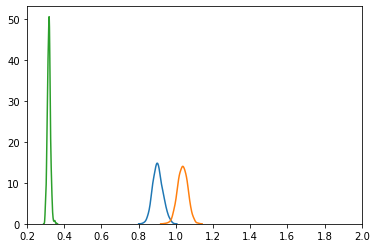

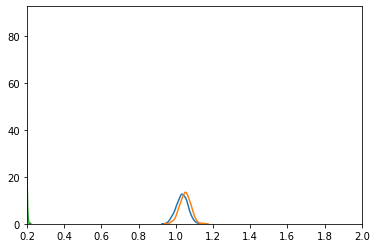

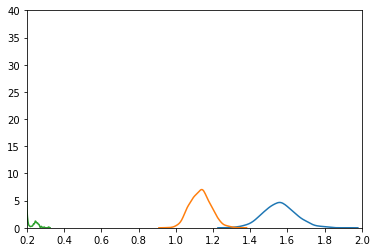

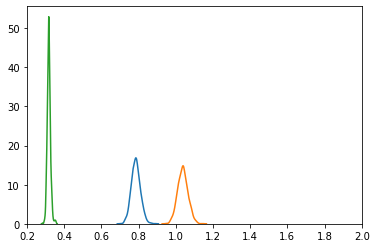

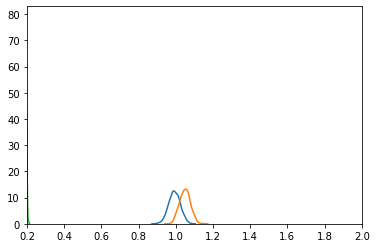

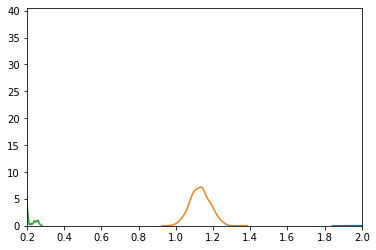

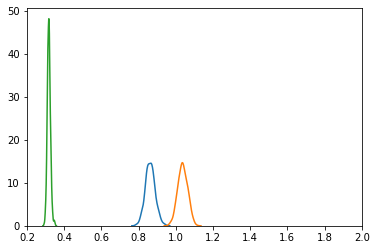

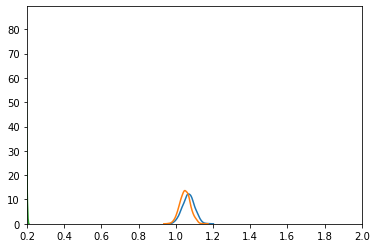

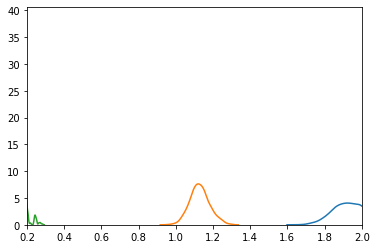

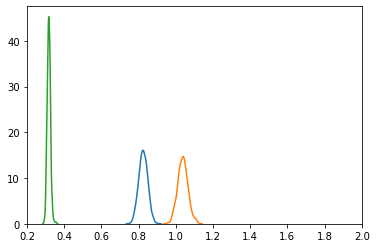

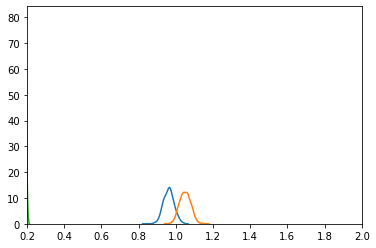

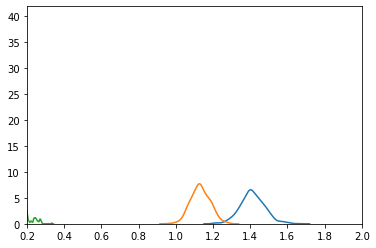

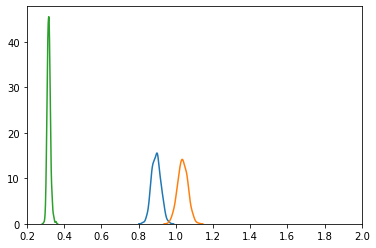

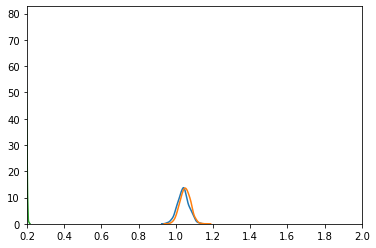

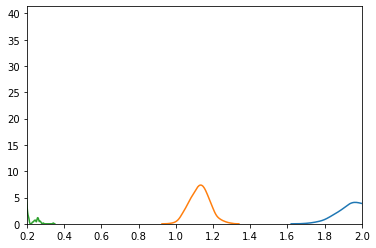

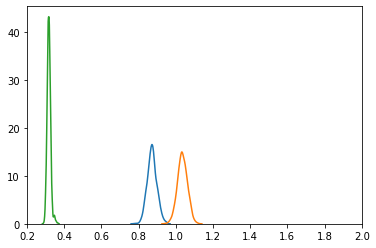

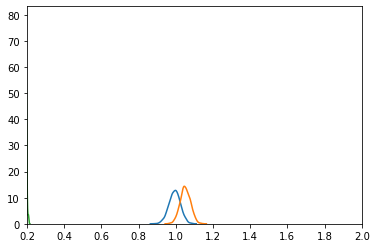

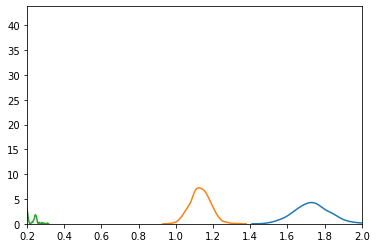

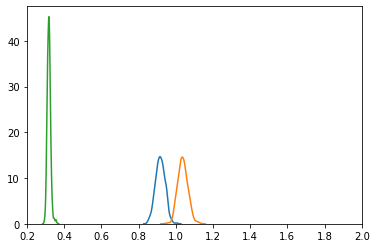

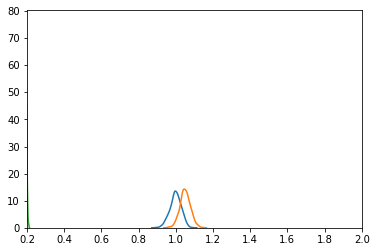

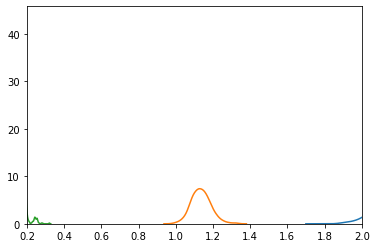

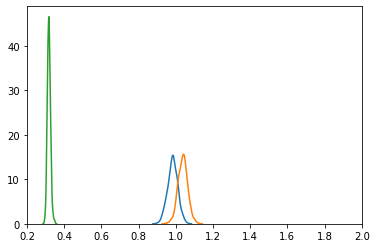

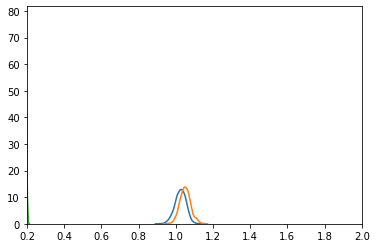

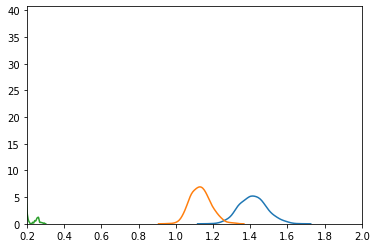

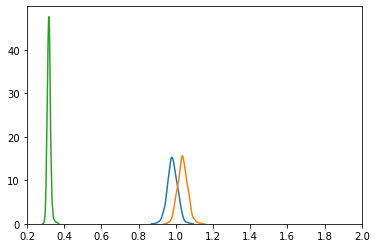

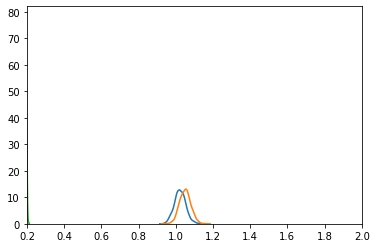

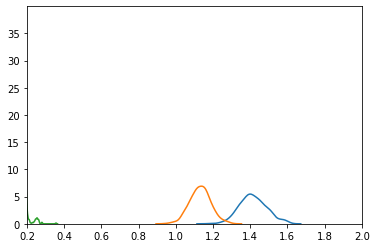

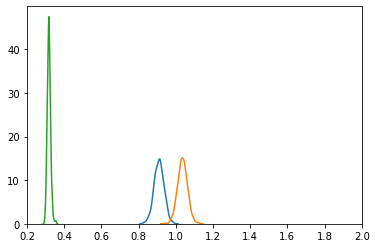

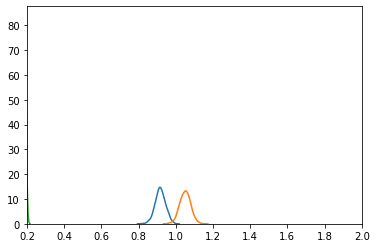

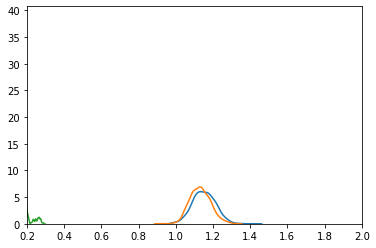

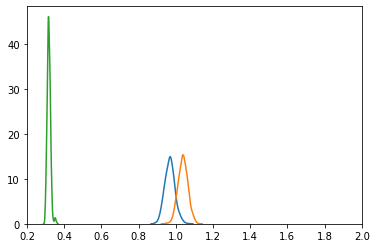

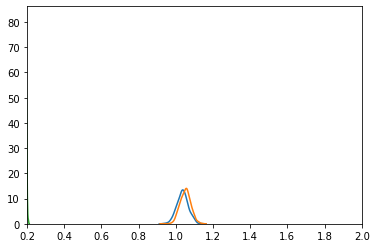

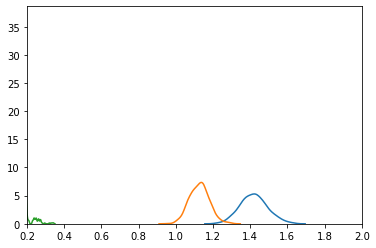

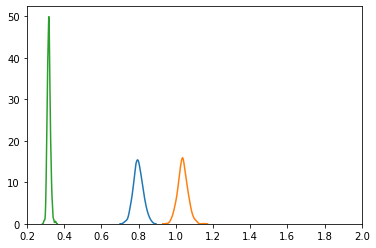

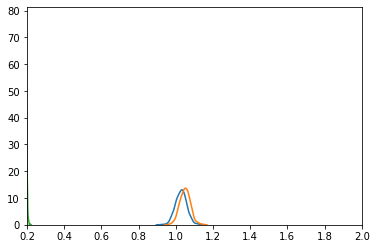

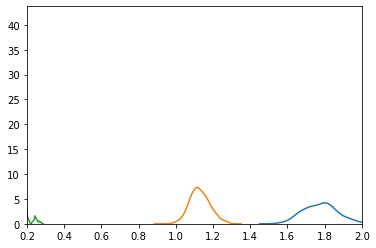

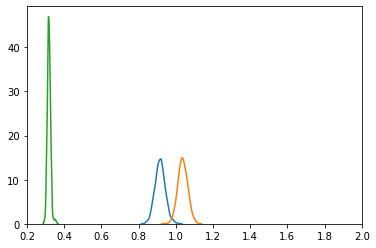

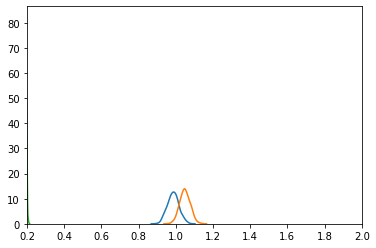

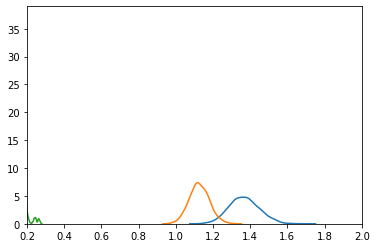

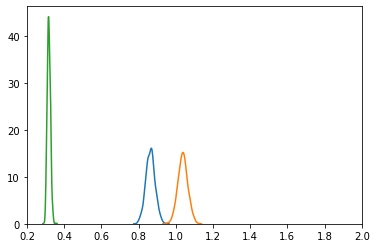

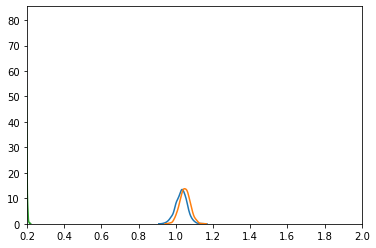

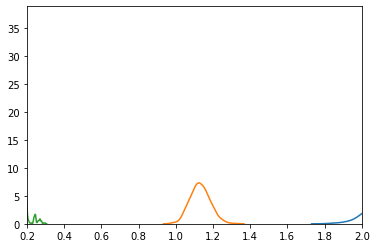

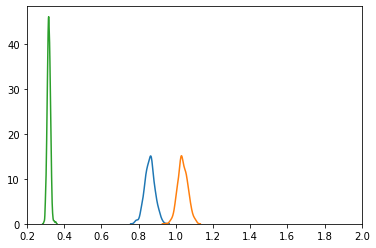

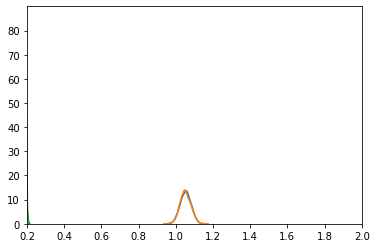

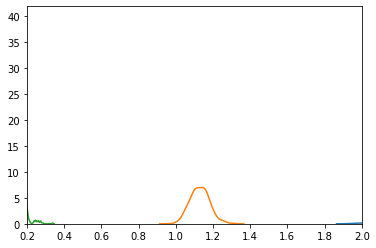

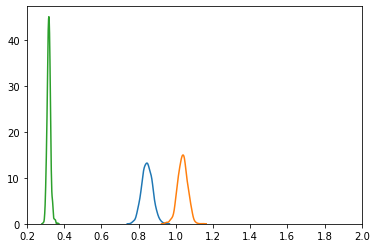

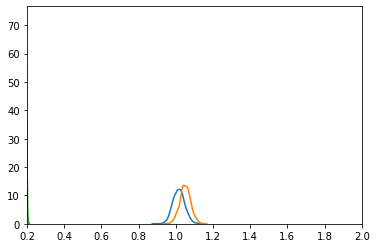

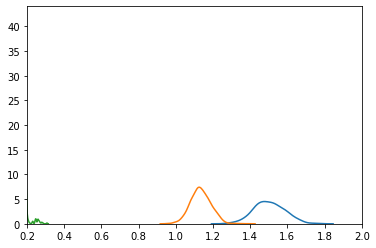

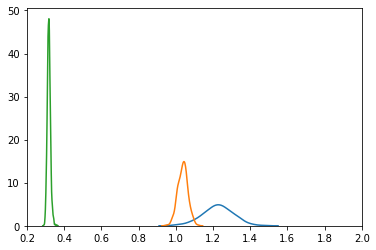

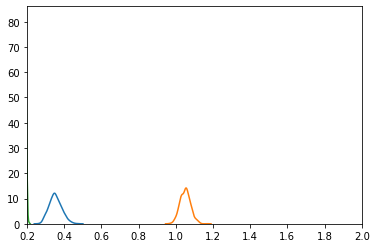

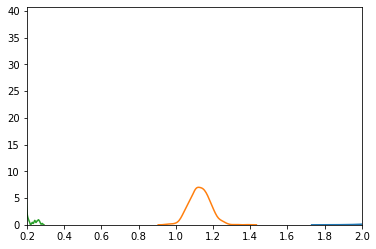

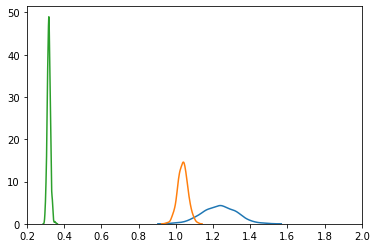

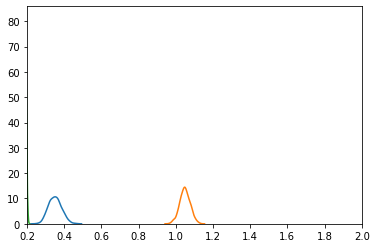

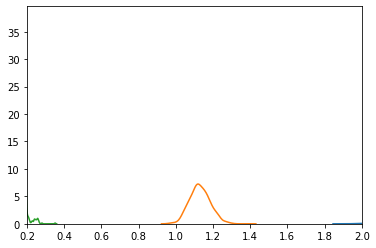

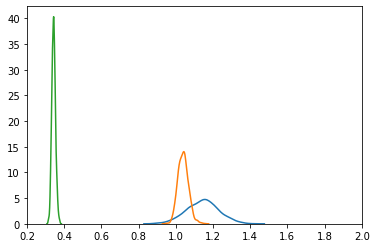

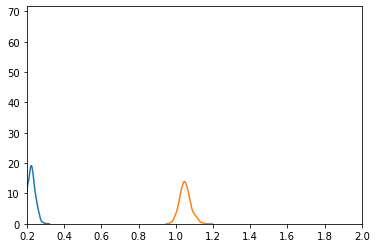

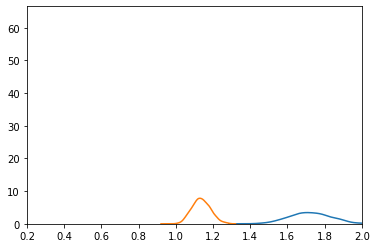

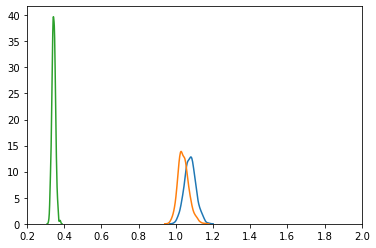

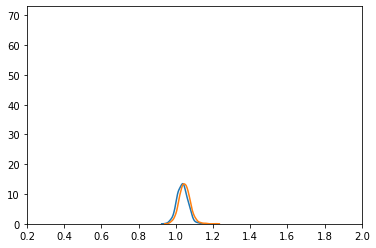

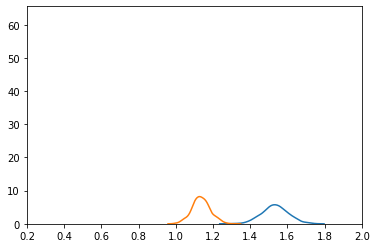

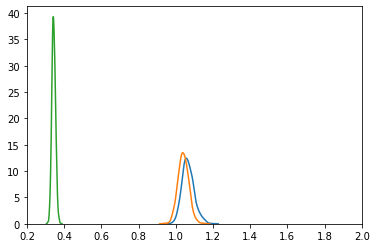

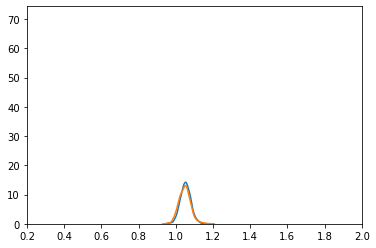

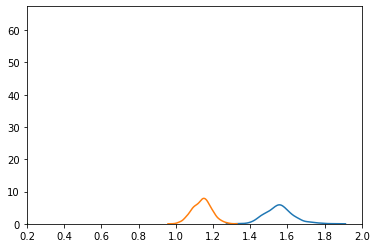

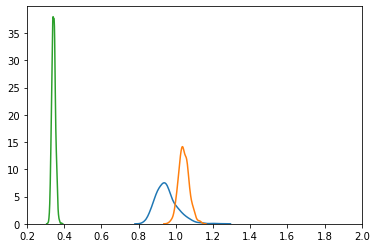

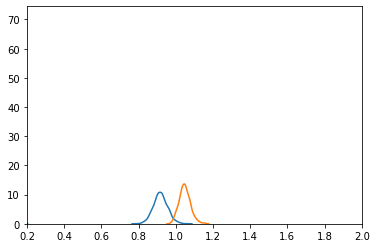

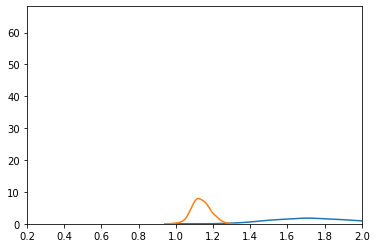

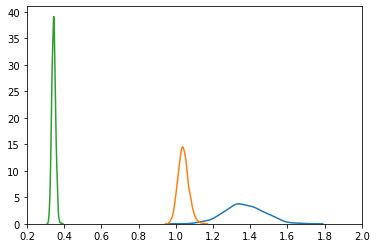

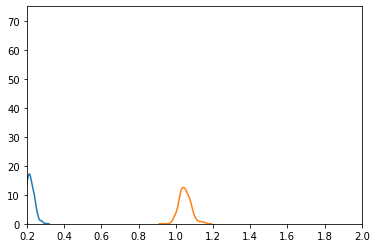

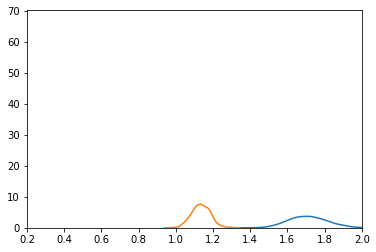

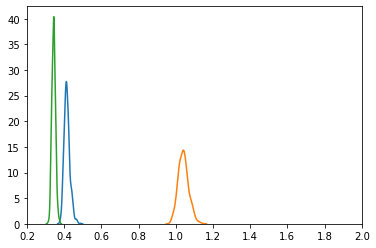

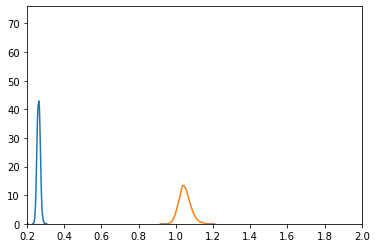

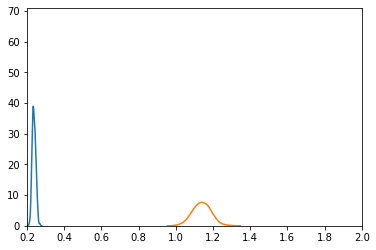

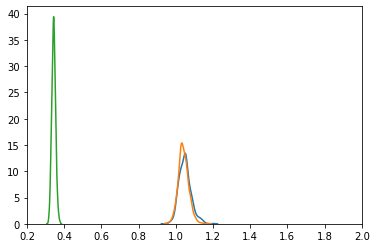

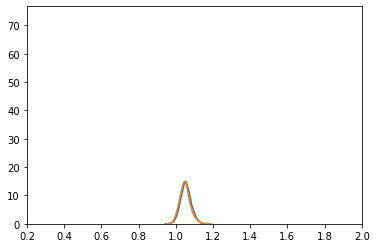

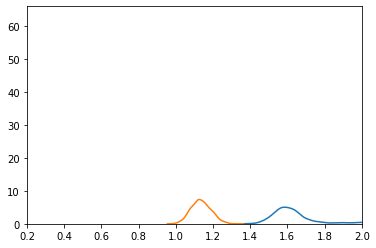

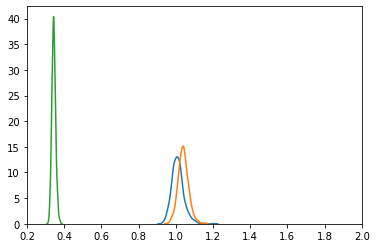

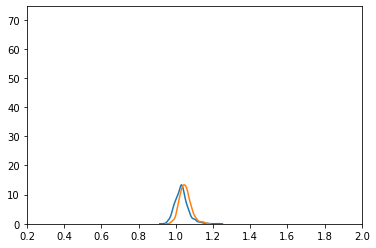

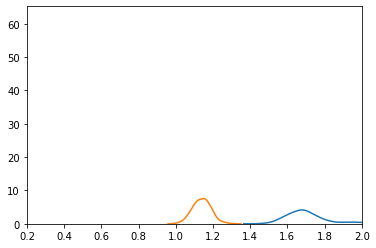

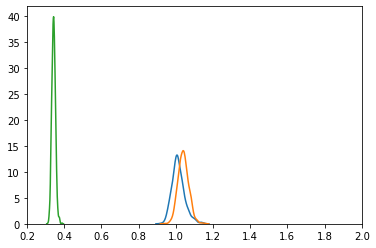

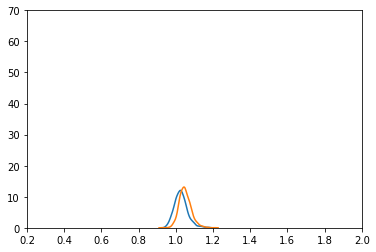

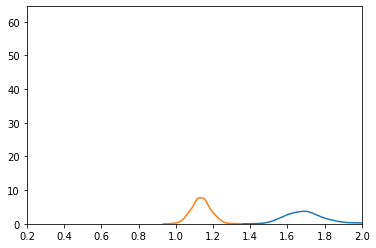

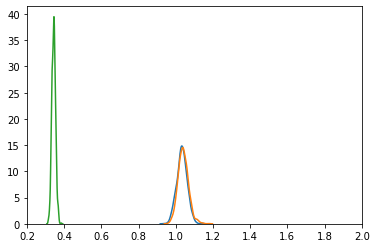

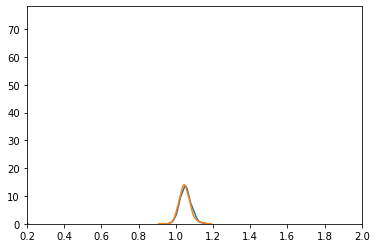

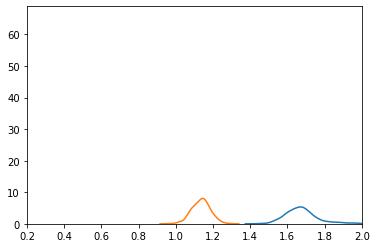

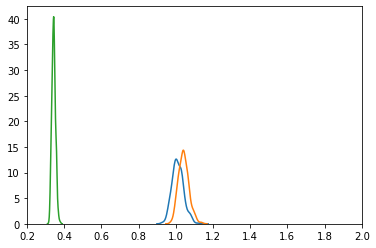

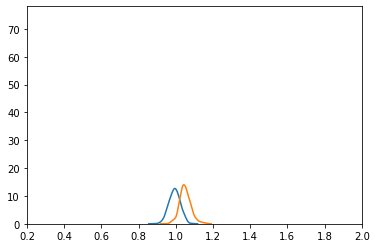

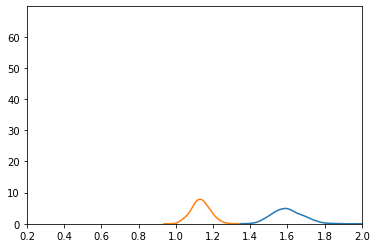

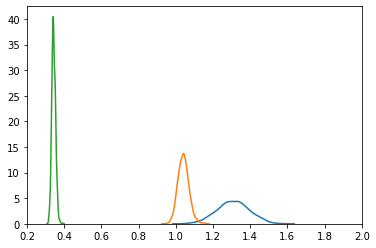

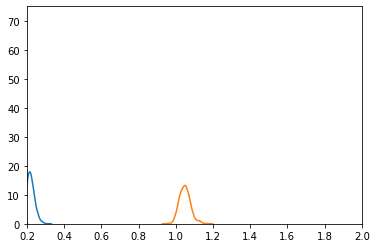

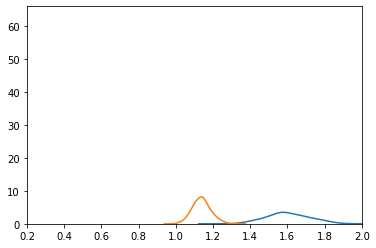

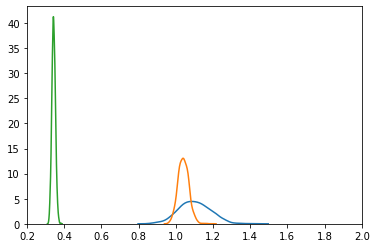

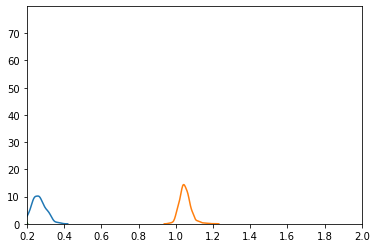

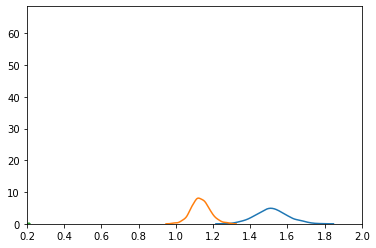

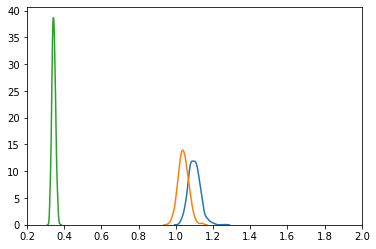

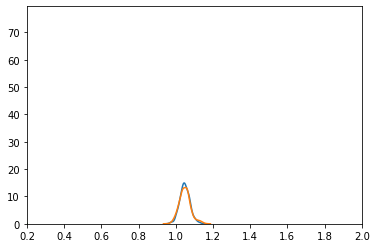

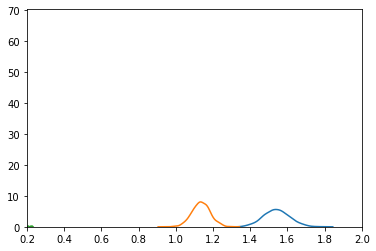

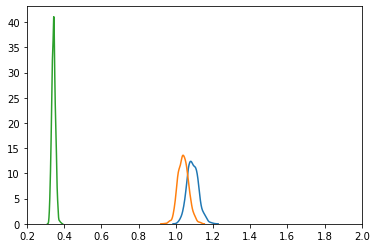

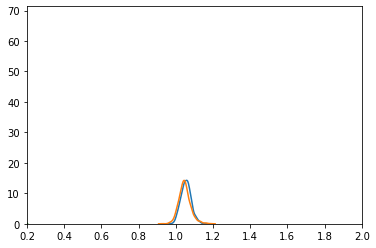

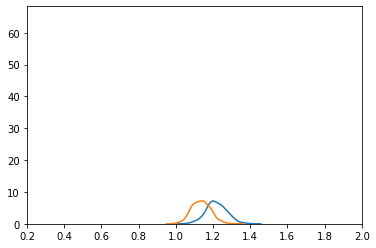

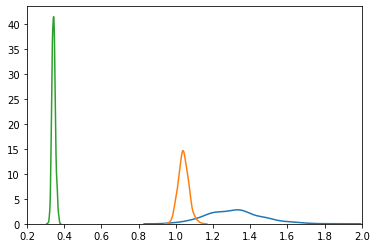

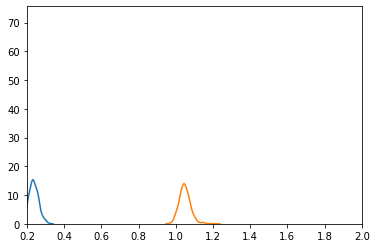

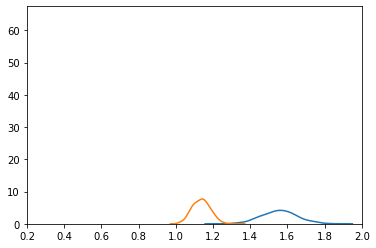

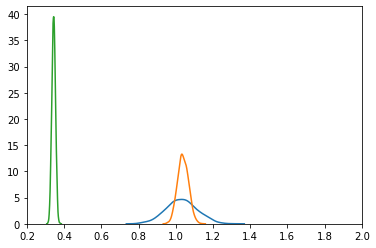

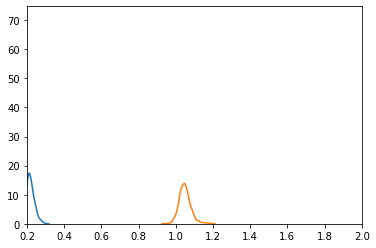

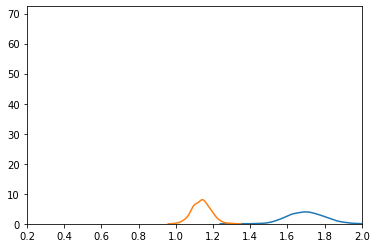

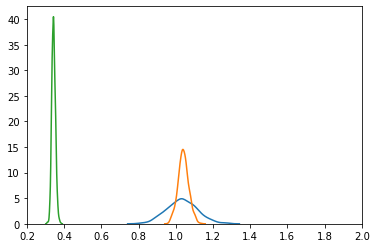

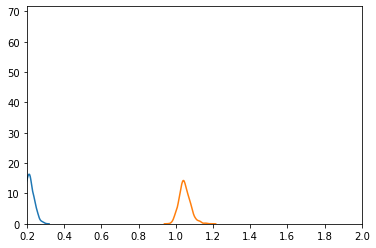

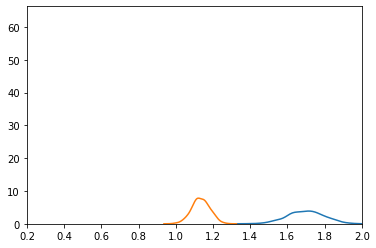

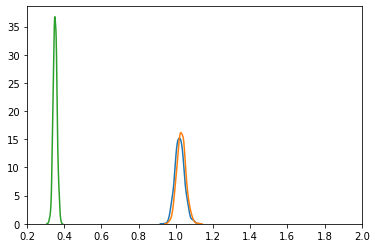

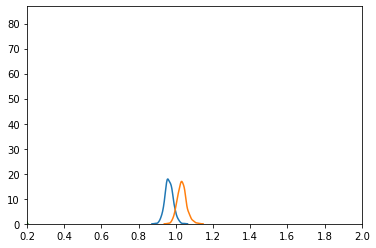

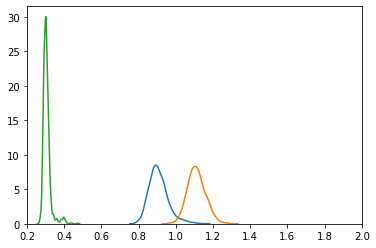

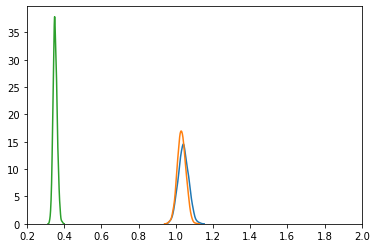

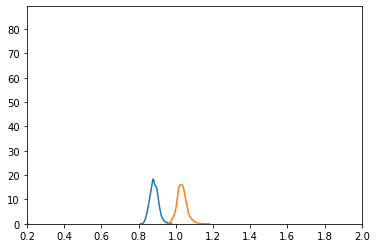

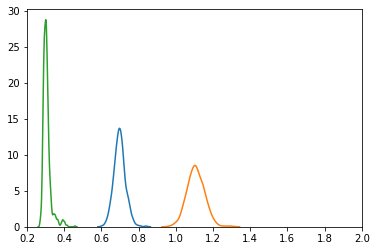

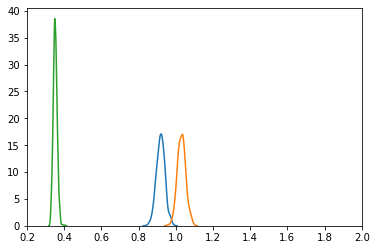

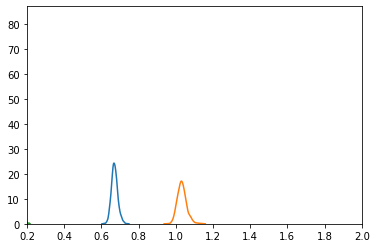

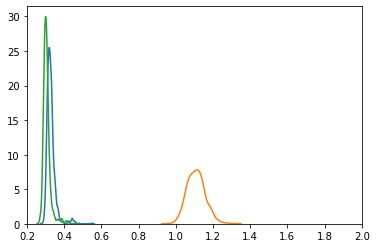

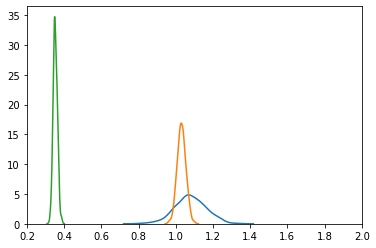

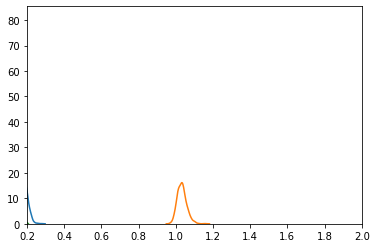

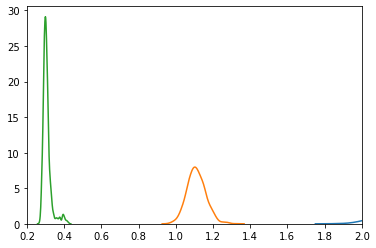

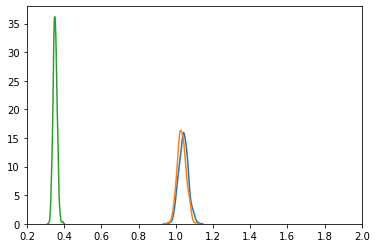

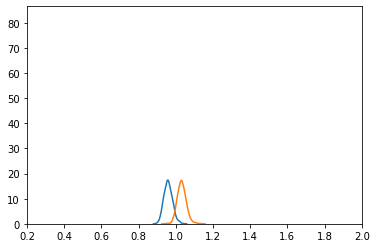

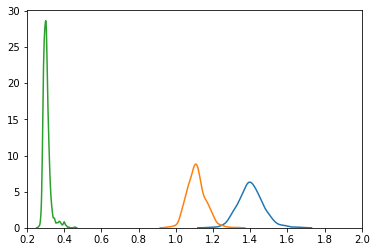

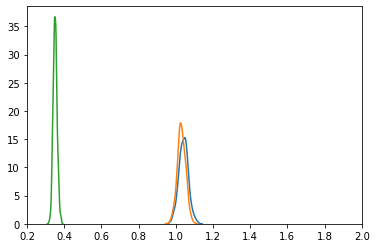

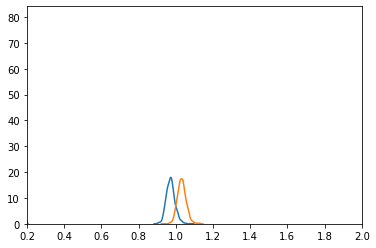

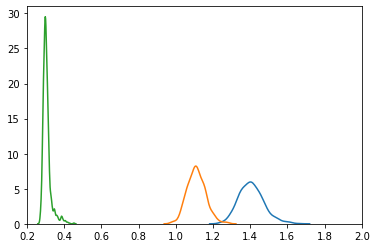

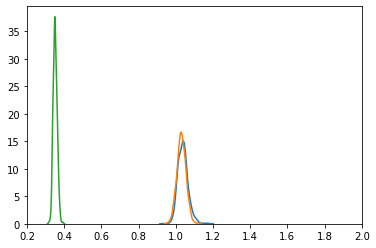

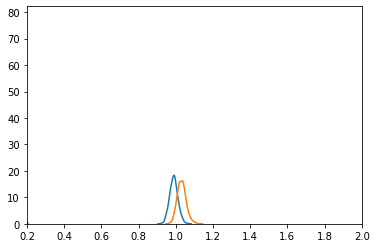

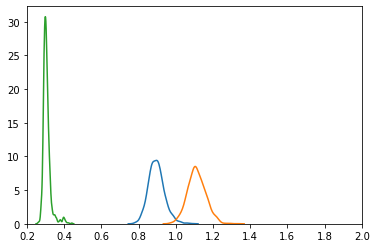

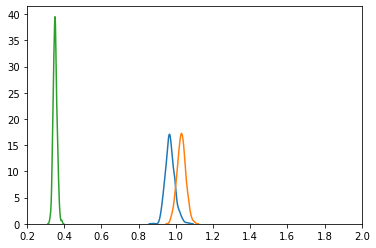

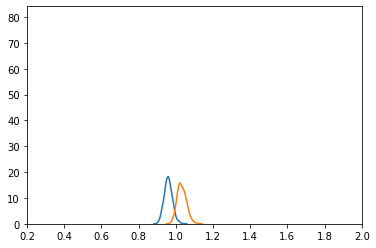

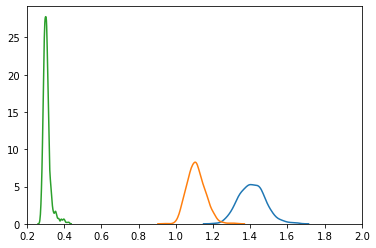

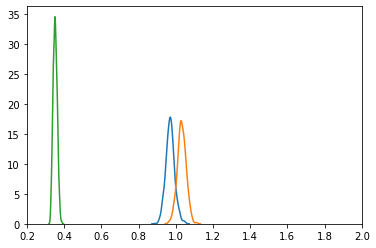

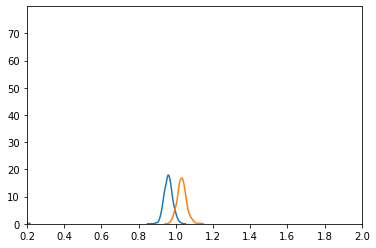

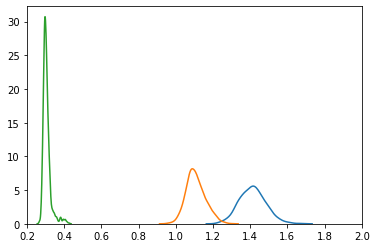

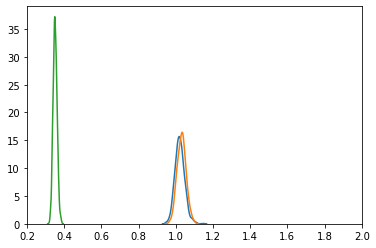

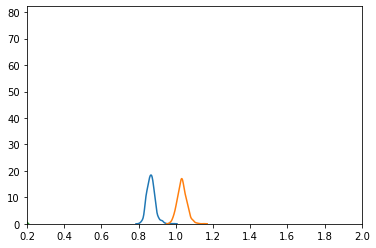

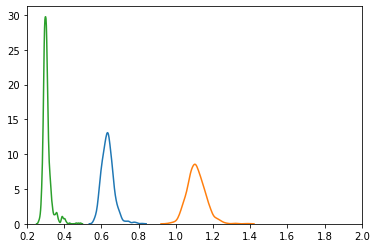

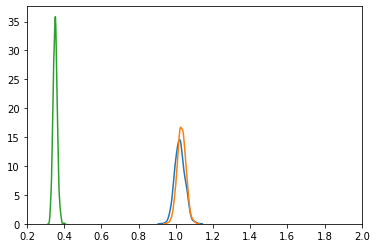

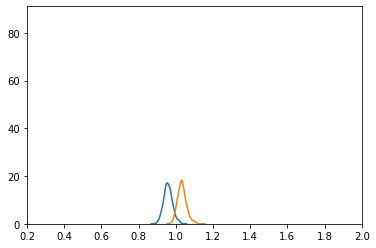

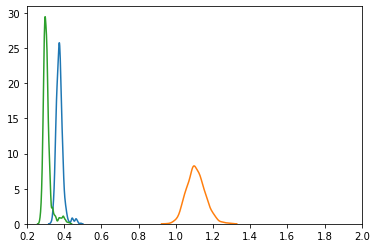

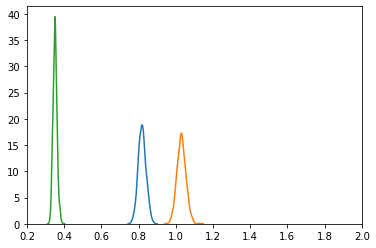

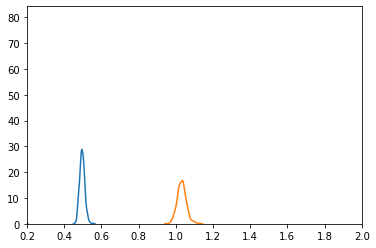

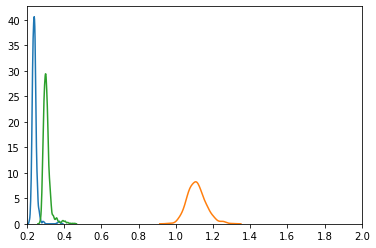

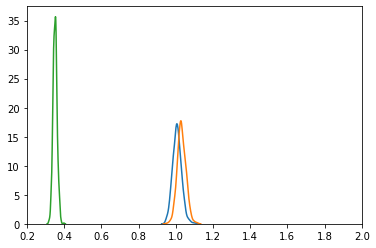

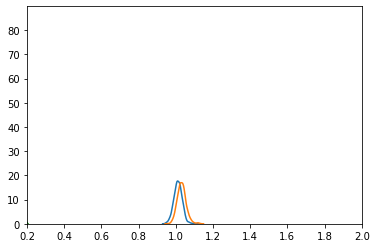

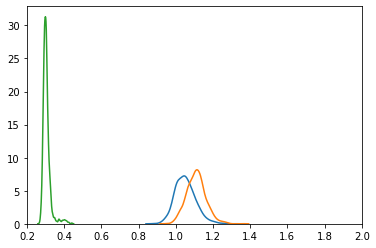

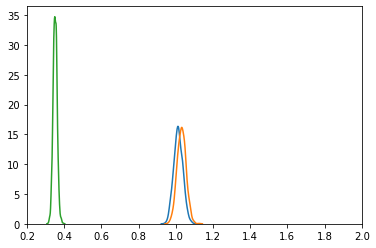

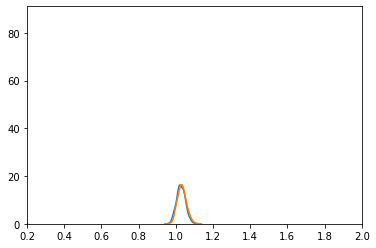

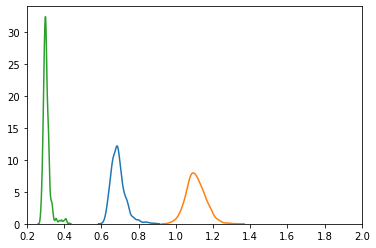

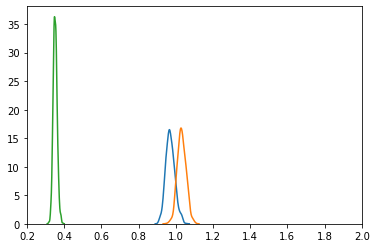

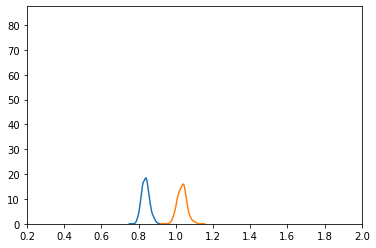

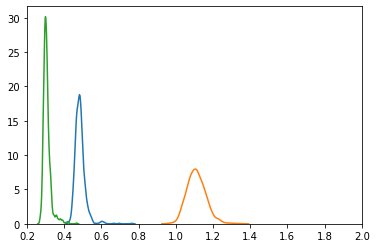

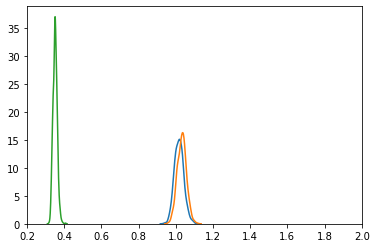

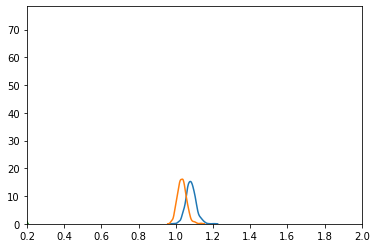

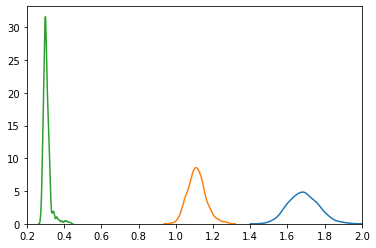

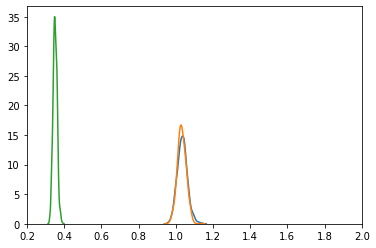

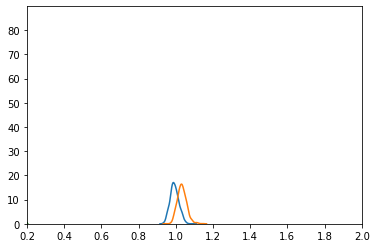

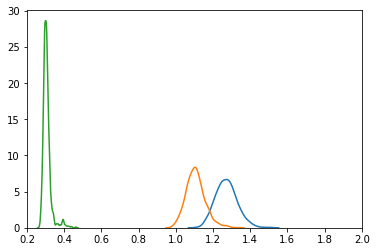

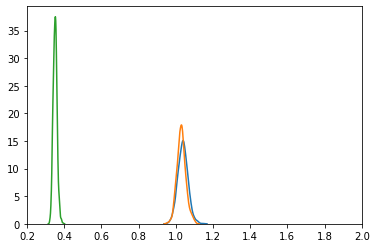

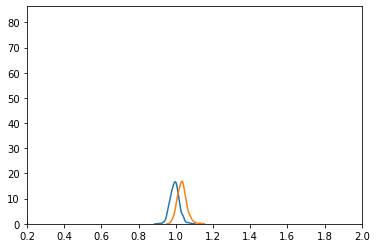

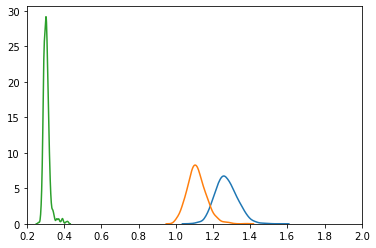

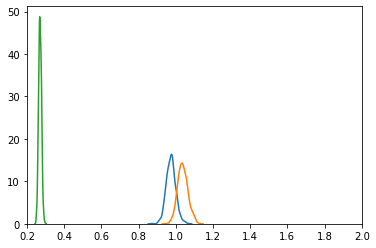

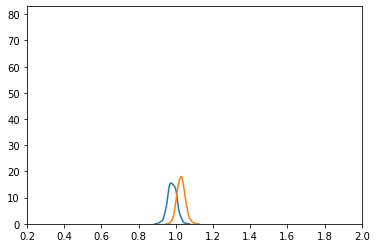

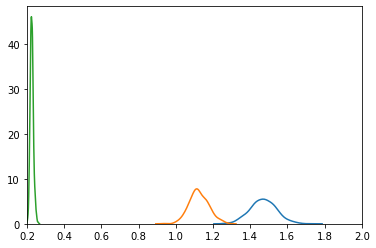

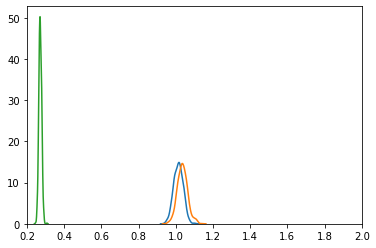

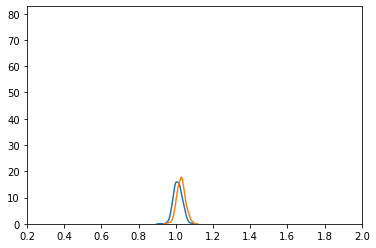

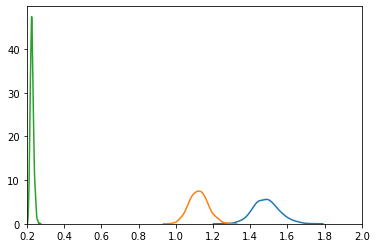

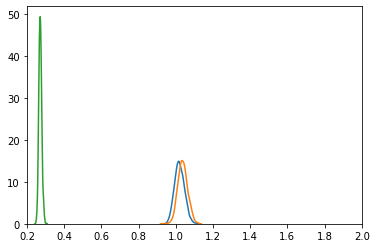

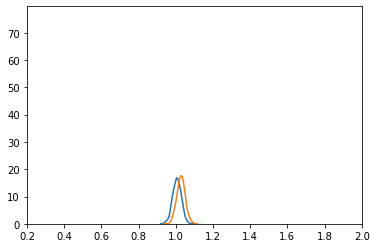

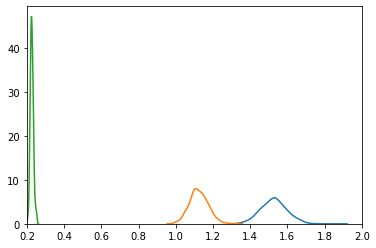

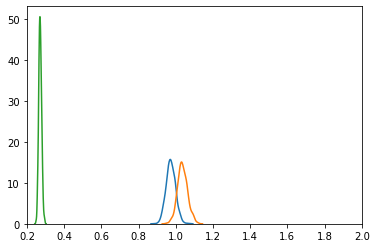

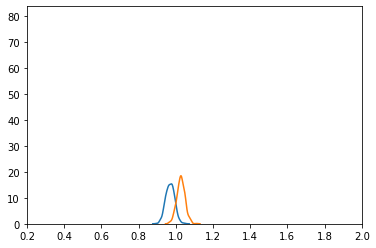

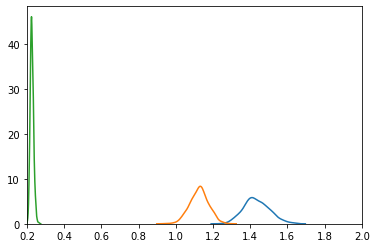

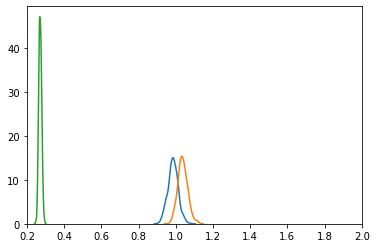

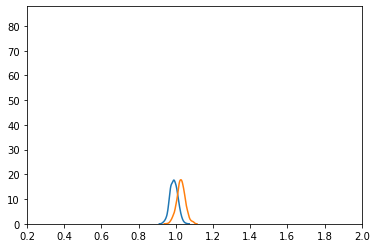

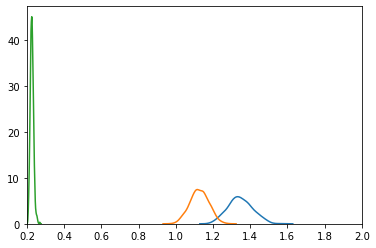

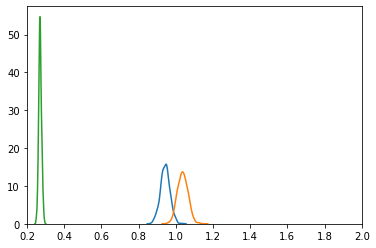

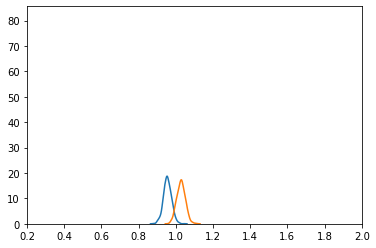

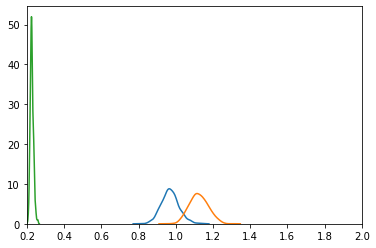

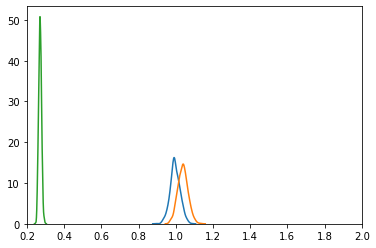

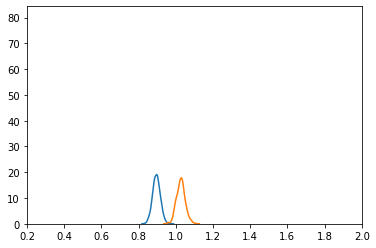

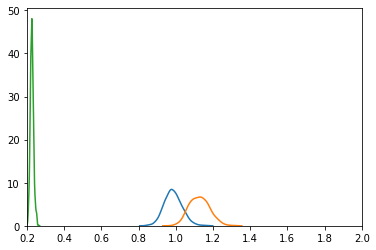

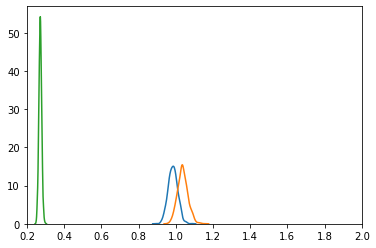

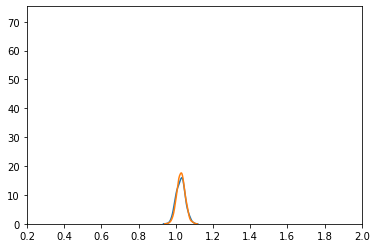

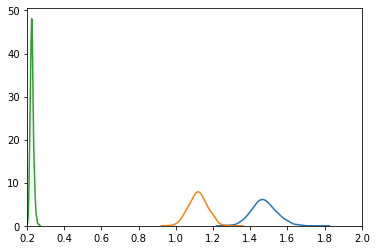

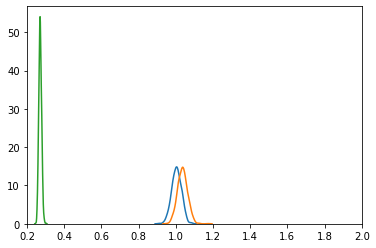

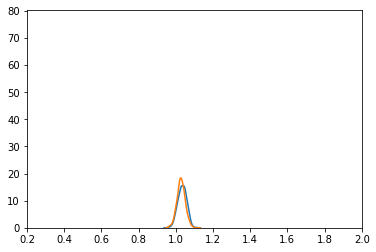

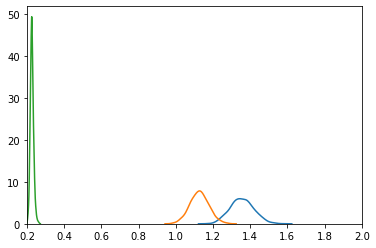

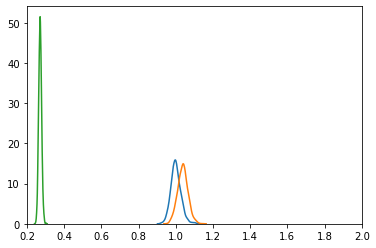

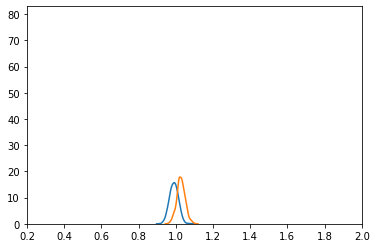

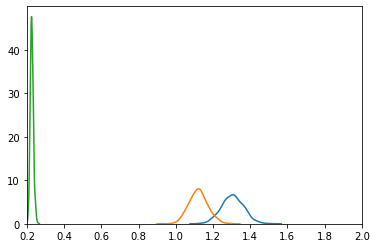

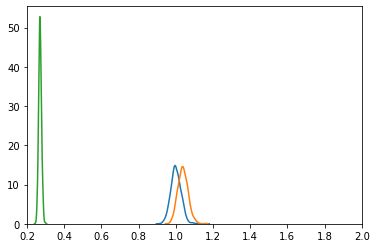

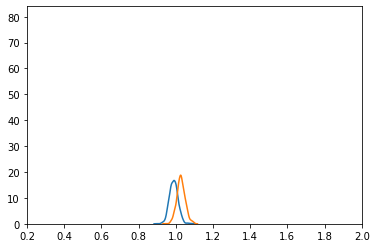

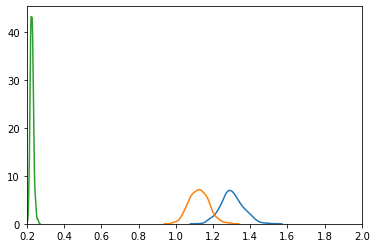

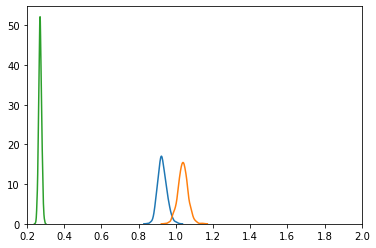

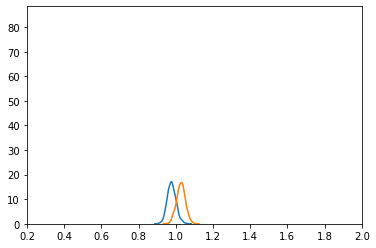

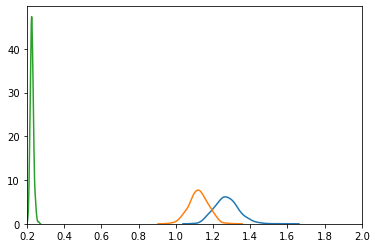

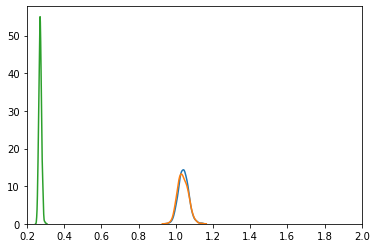

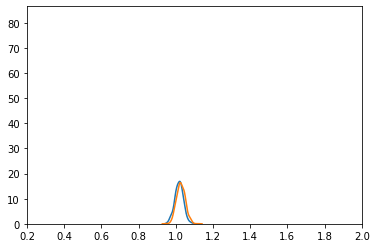

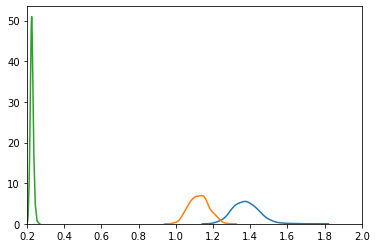

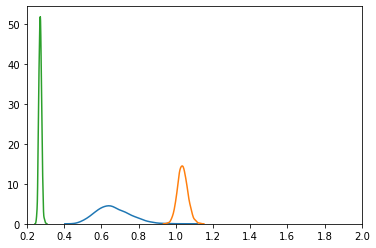

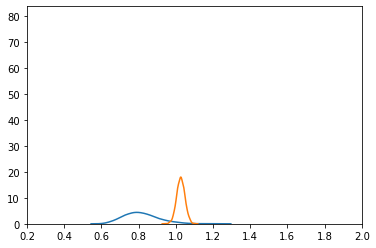

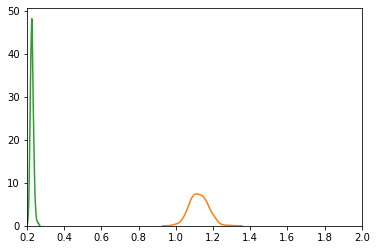

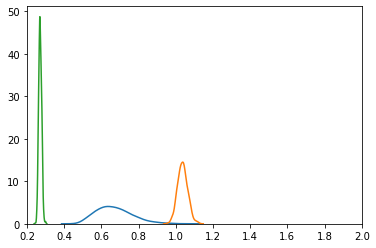

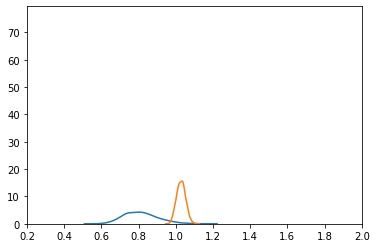

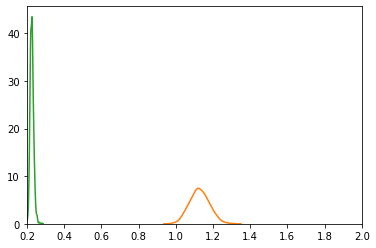

In [172]:
### order is 111, 110, 136
all_mutants = []
for layer1data,layer1dfs in zip(sets,sets_dfs):
    substrates = ['111','110','136']
    i = 0
    for layer2data,layer2dfs in zip(layer1data,layer1dfs):
        ### bootstrap data
        test = bootstrap(pd.DataFrame(layer2data))
        ###  get wt and mutant
        mutant = test.iloc[0]
        wt = test.iloc[1]
        ### create normal distributions from the data and test
        normal_wt = np.random.normal(np.mean(wt),np.std(wt,ddof=1),10000)
        wt_lo = np.percentile(a=normal_wt,q=1.0)
        wt_hi = np.percentile(a=normal_wt,q=99.0)
        normal_item = np.random.normal(np.mean(mutant),np.std(wt,ddof=1),10000)
        overlap = normal_item[normal_item > wt_lo]
        overlap = len(overlap)/len(normal_item)
        ### grab the mutant from the data df
        single = layer2dfs.iloc[0]
        ### combine
        single['pval'] = overlap
        ### name
        single.name = substrates[i]+'_'+single.mutant+'_'+single.subunit
        ### append
        all_mutants.append(single)
        ###
        i+=1

### calculate p value and save the below test

In [173]:
mutants_dist = pd.concat(all_mutants,axis=1,join='inner').transpose()
mutants_dist['substrate'] = mutants_dist.apply(lambda row: row.name.split('_')[0],axis=1)
mutants_dist['mutation'] = mutants_dist.apply(lambda row: row.name.split('_')[1],axis=1)
mutants_dist['subunit'] = mutants_dist.apply(lambda row: row.name.split('_')[2],axis=1)
mutants_dist.to_csv('figures_kde/full.final_pvalues.01cutoff.csv')
final = mutants_dist[['substrate','mutation','subunit','pval']]
final.to_csv('figures_kde/final_pvalues.01cutoff.csv')

### redo with greater than test

/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop

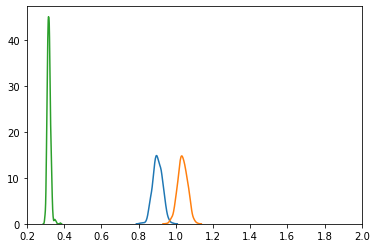

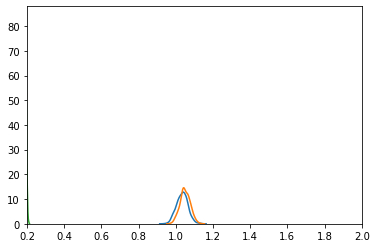

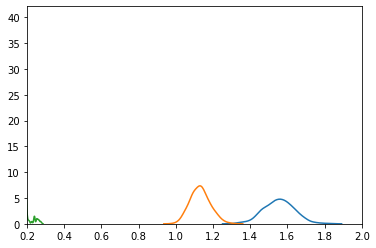

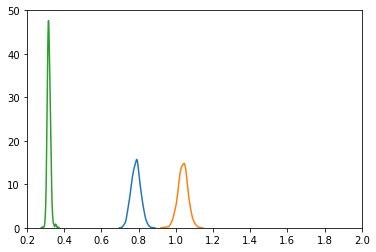

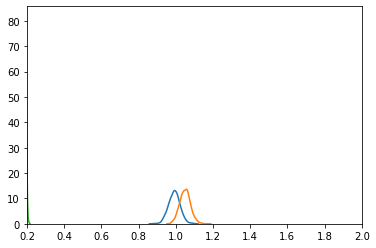

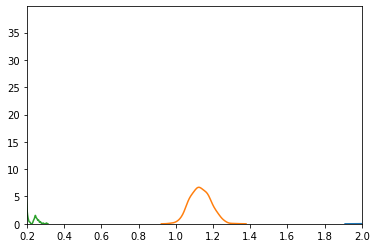

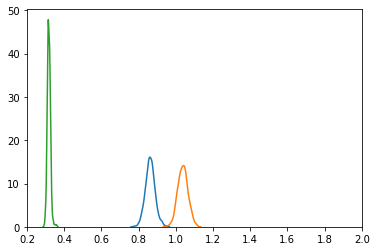

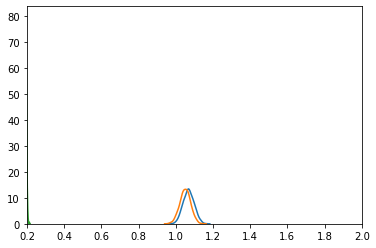

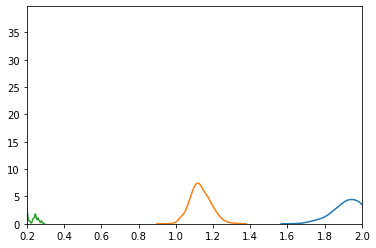

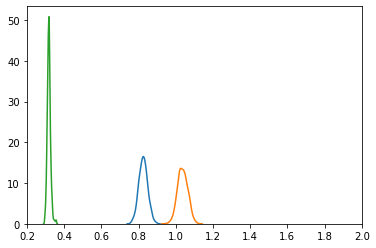

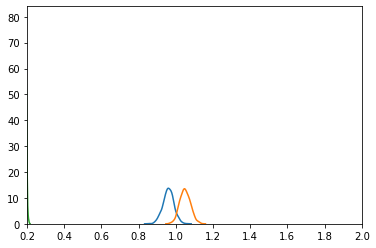

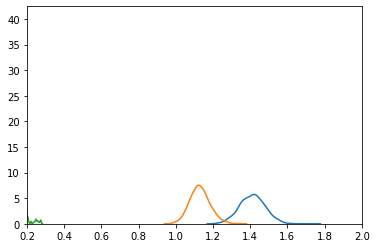

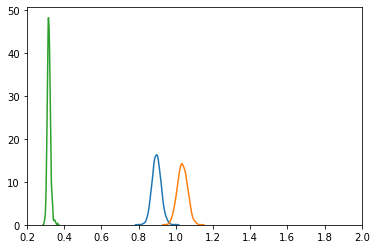

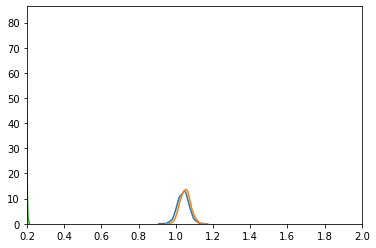

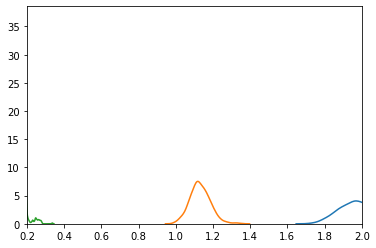

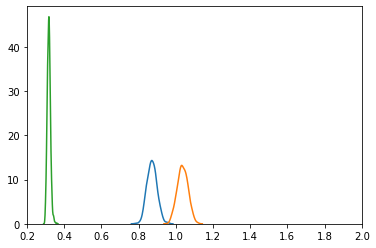

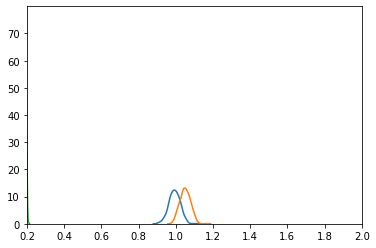

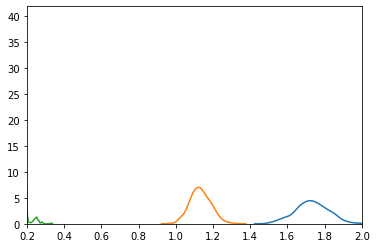

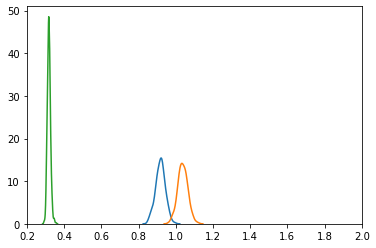

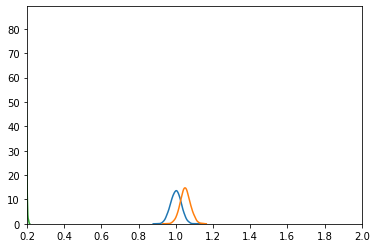

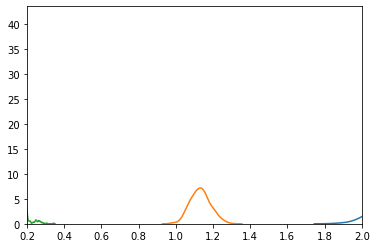

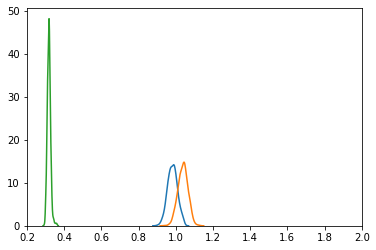

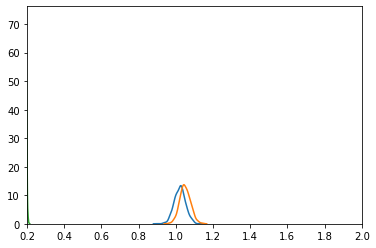

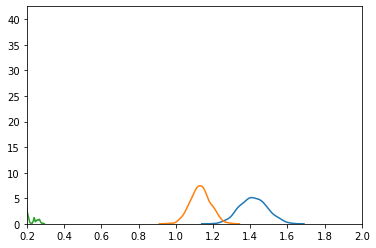

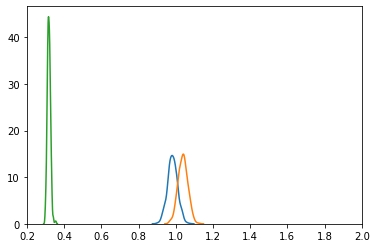

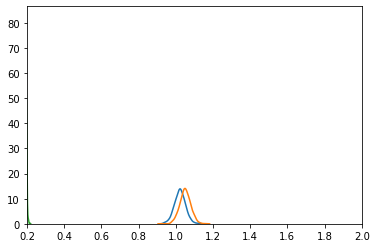

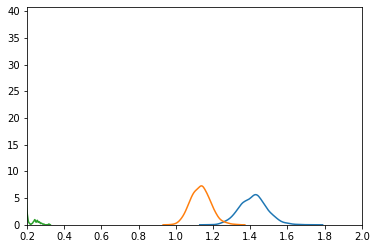

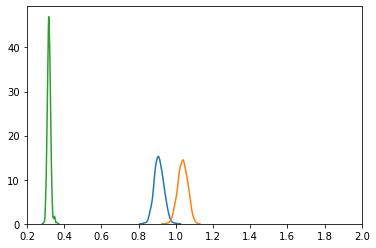

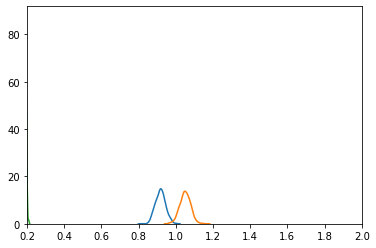

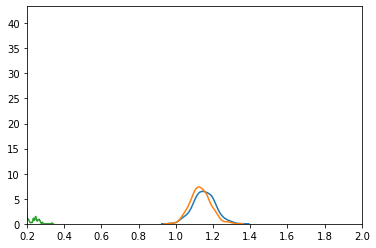

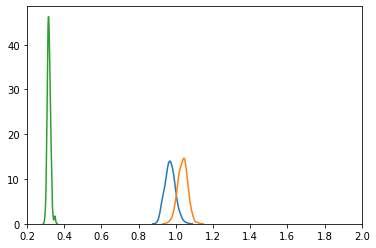

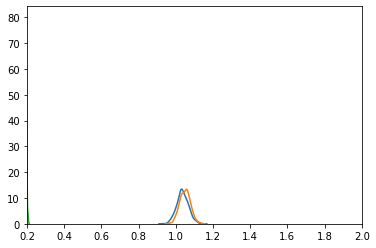

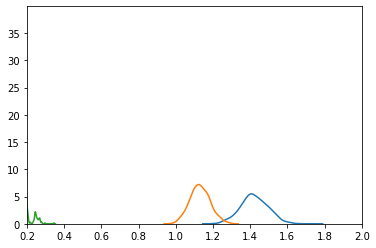

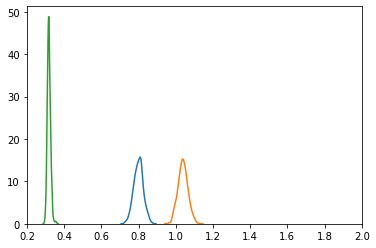

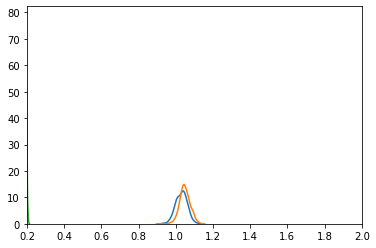

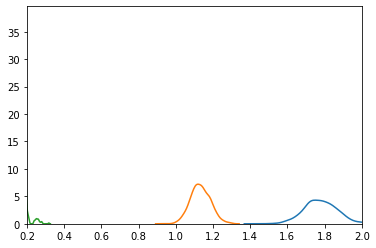

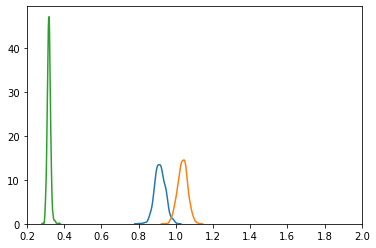

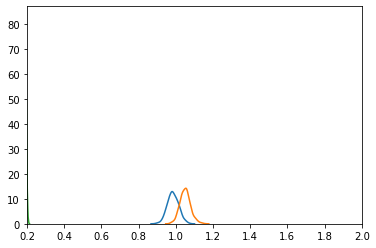

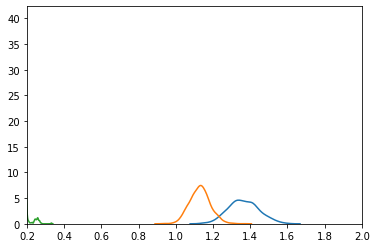

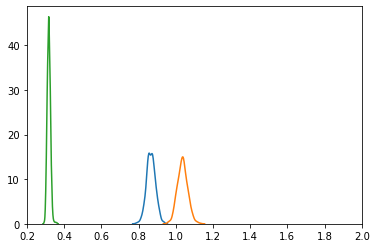

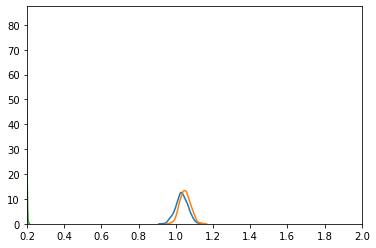

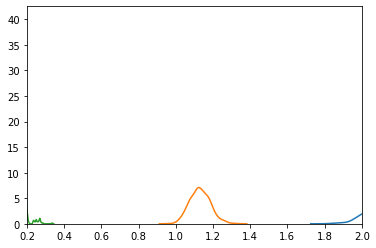

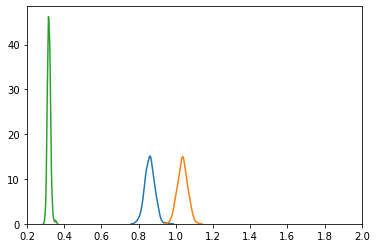

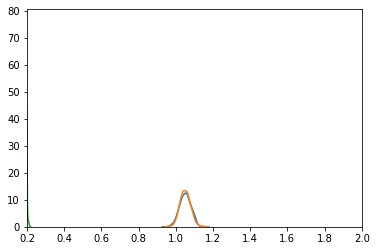

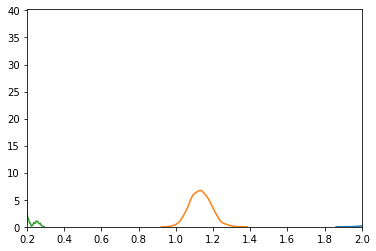

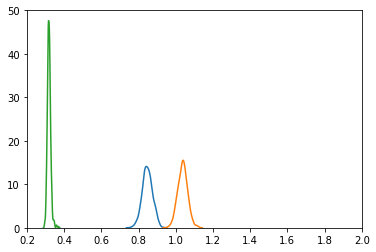

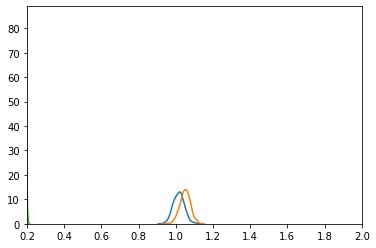

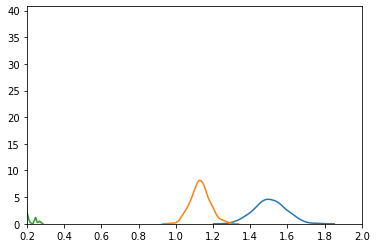

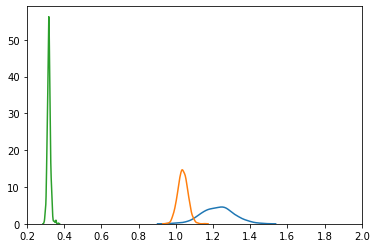

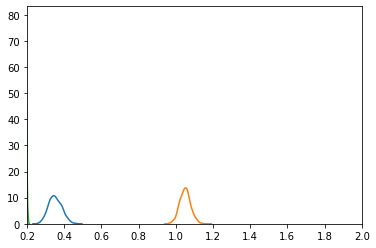

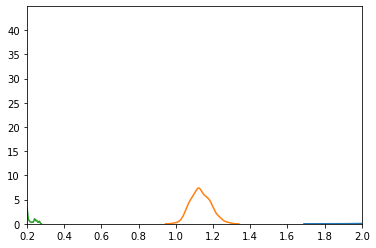

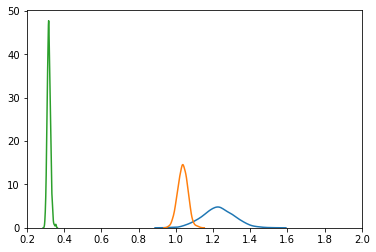

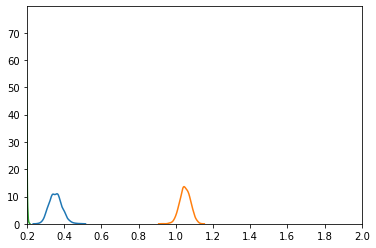

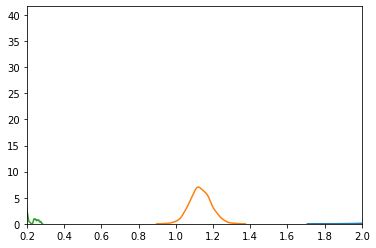

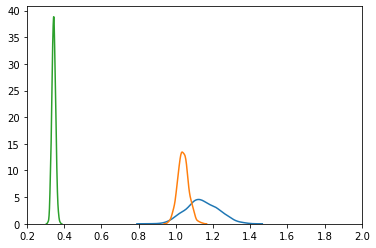

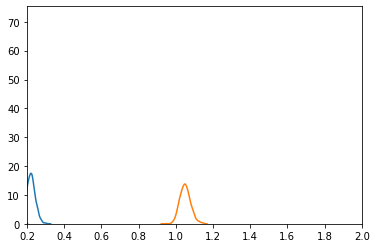

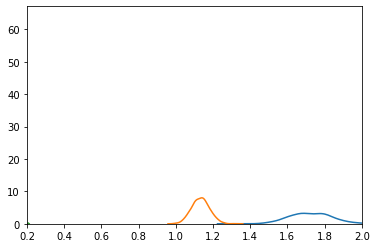

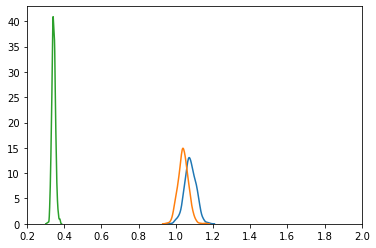

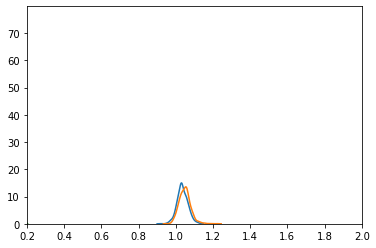

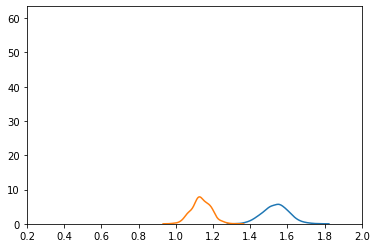

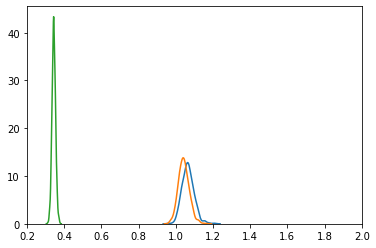

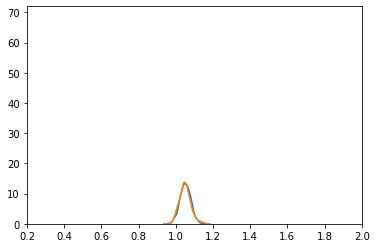

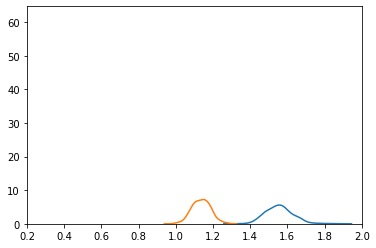

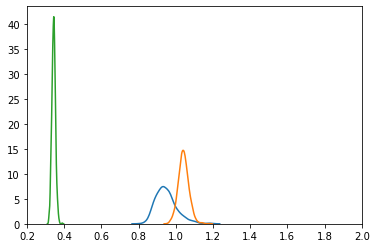

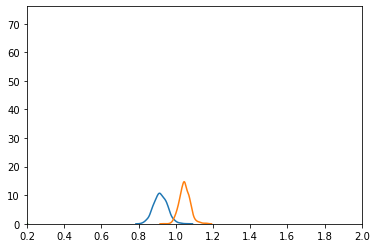

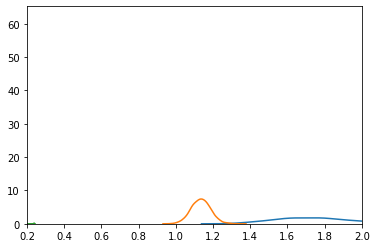

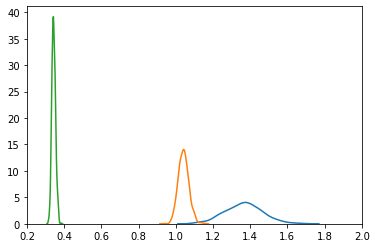

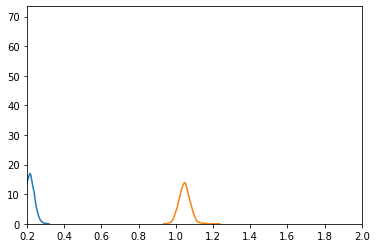

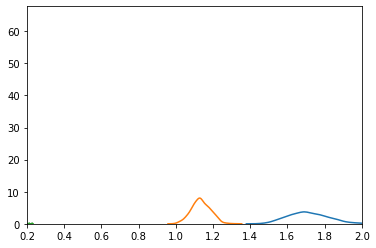

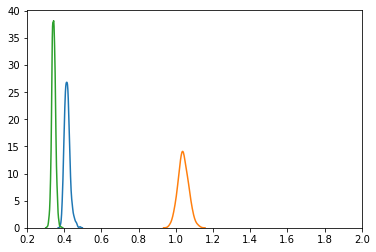

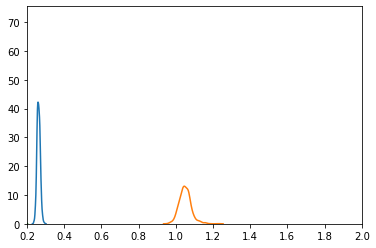

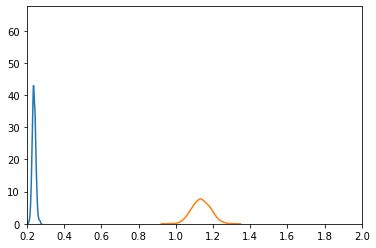

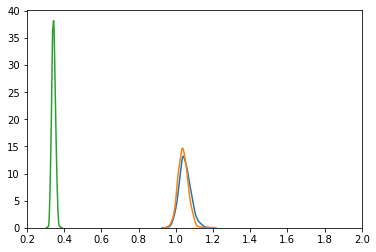

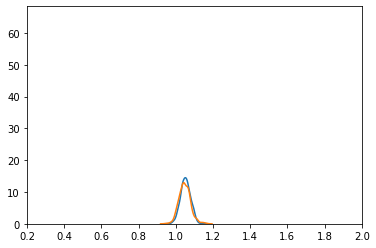

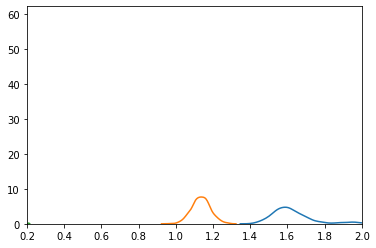

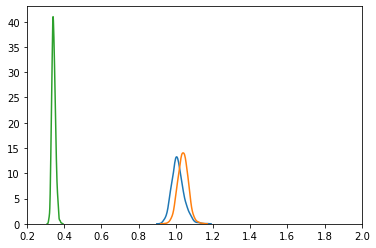

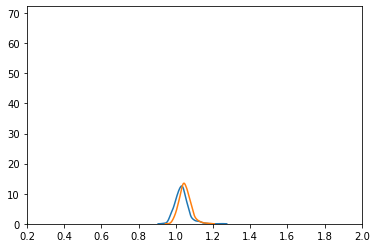

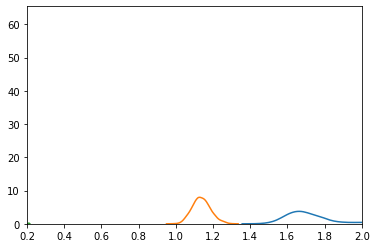

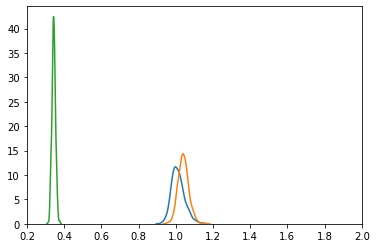

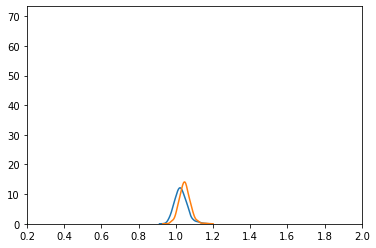

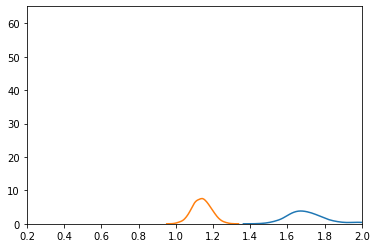

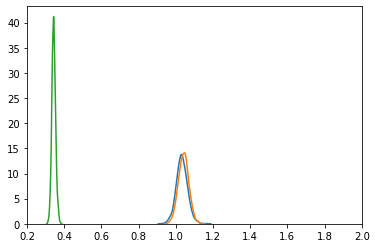

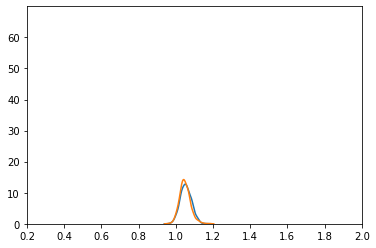

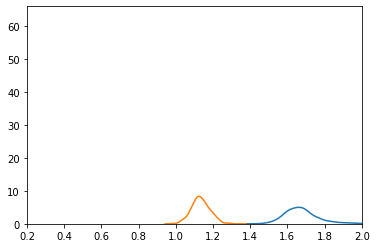

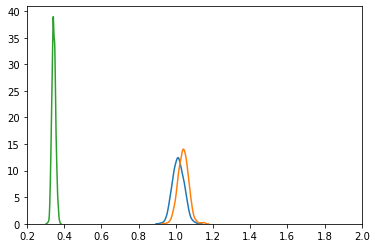

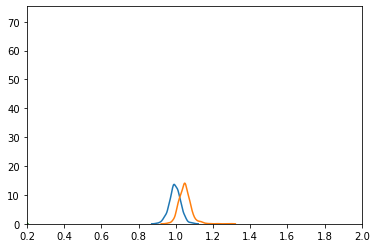

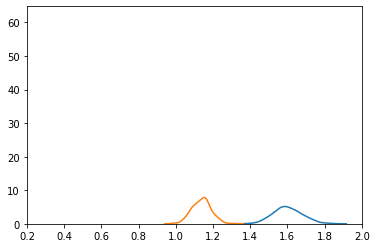

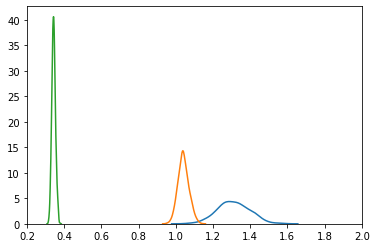

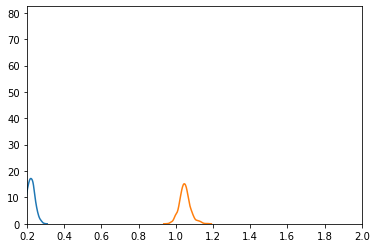

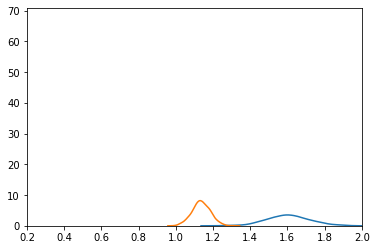

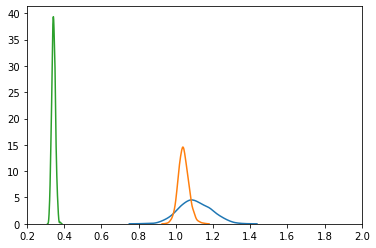

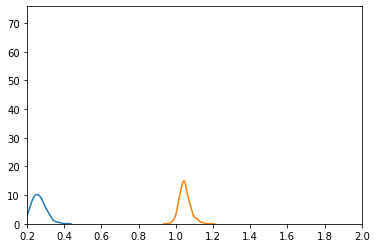

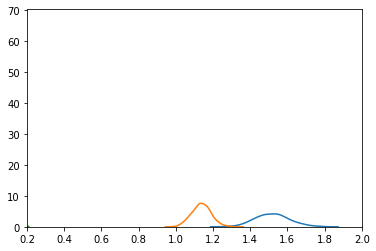

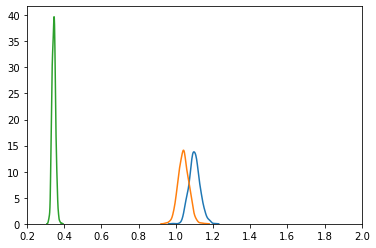

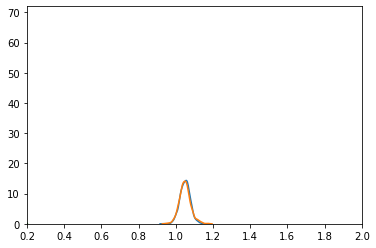

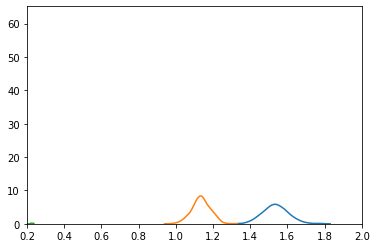

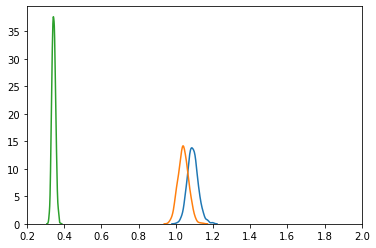

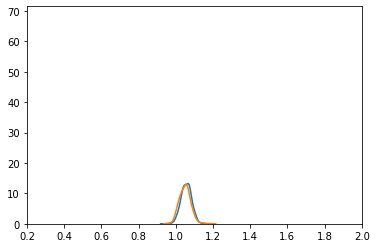

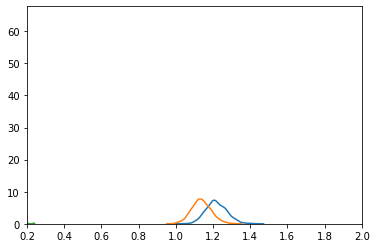

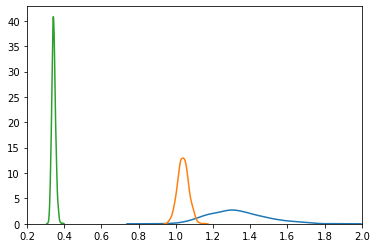

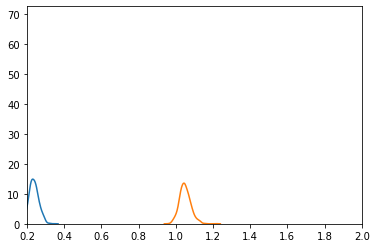

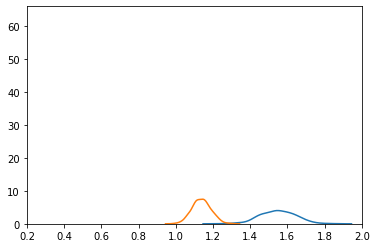

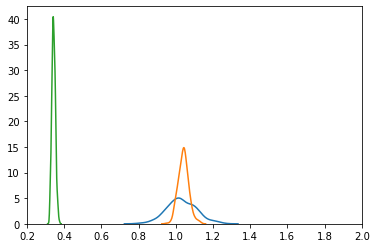

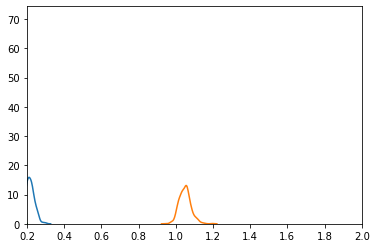

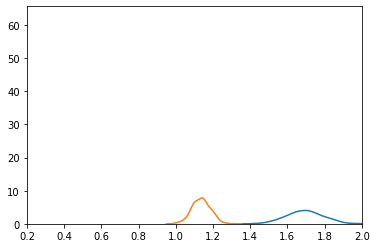

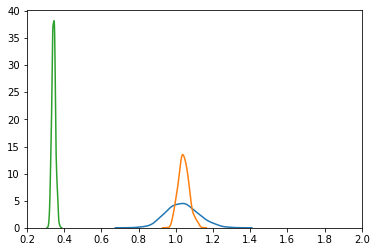

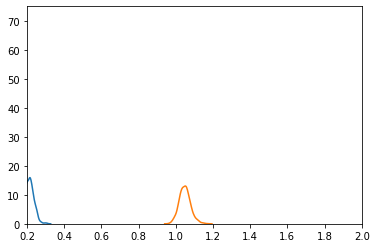

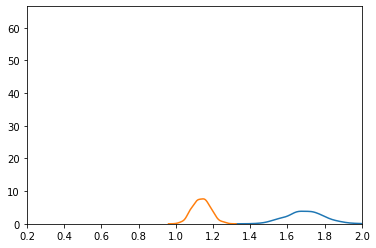

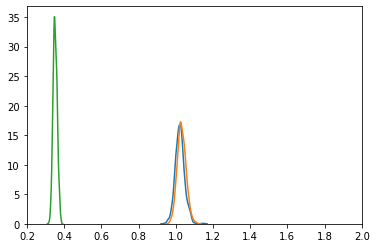

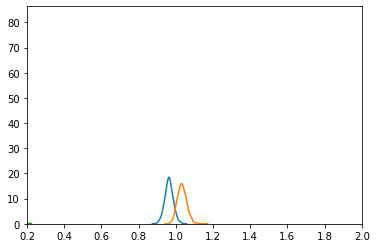

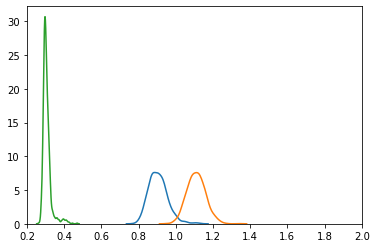

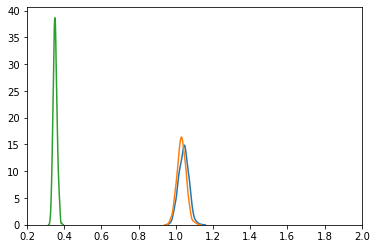

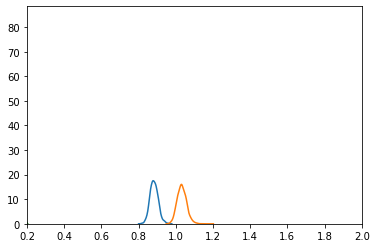

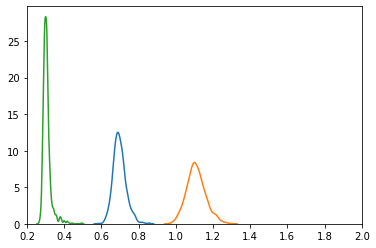

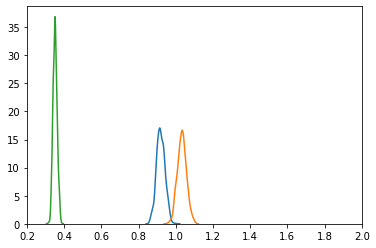

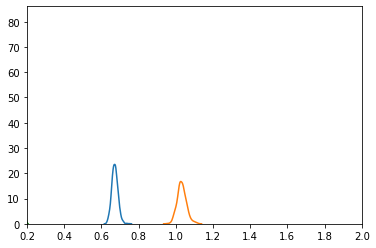

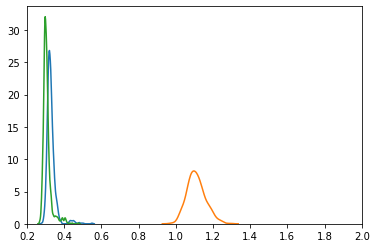

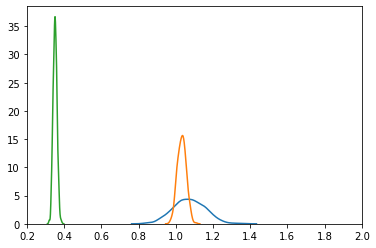

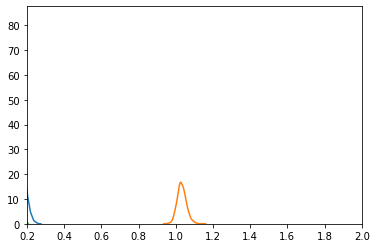

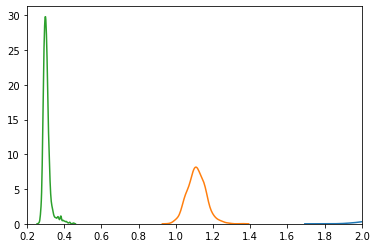

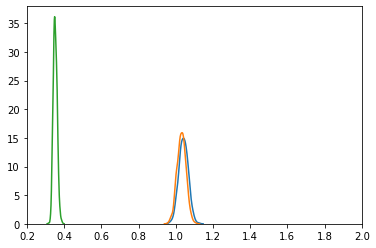

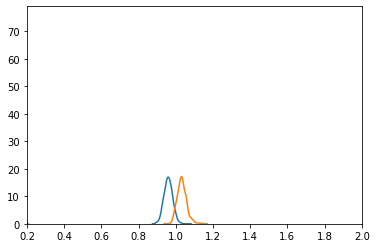

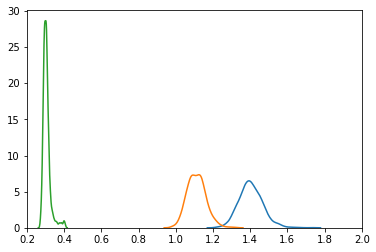

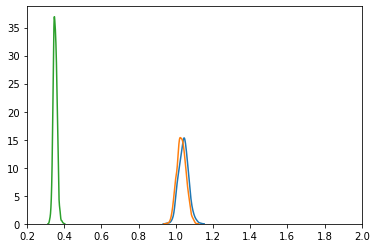

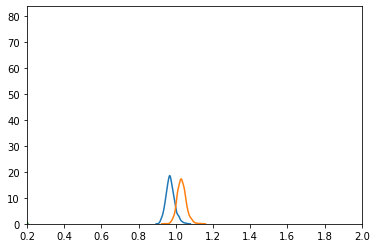

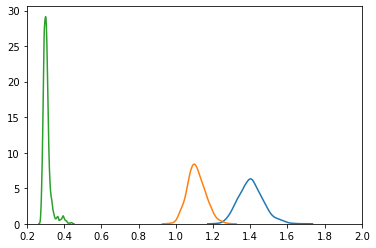

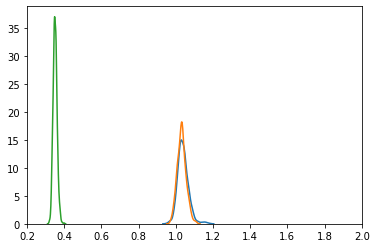

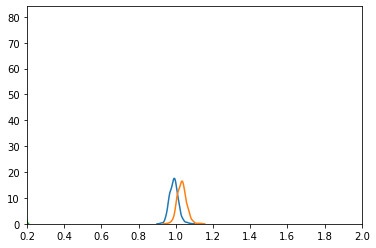

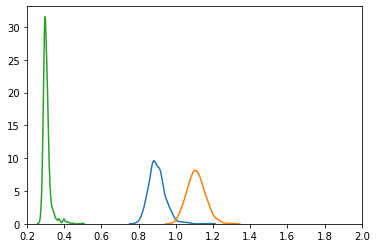

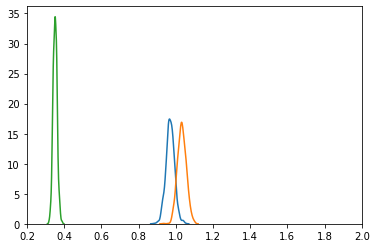

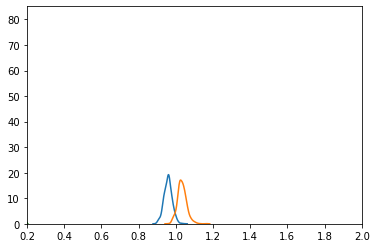

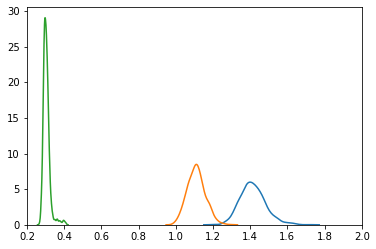

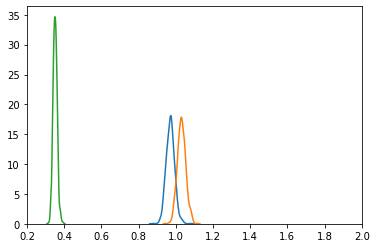

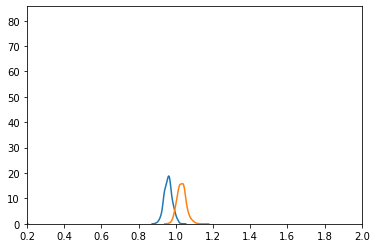

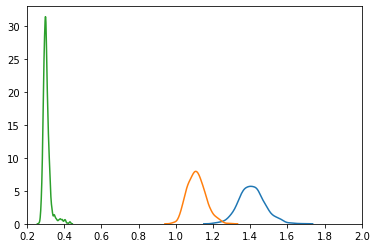

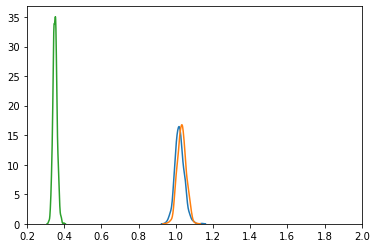

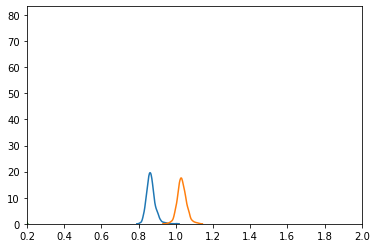

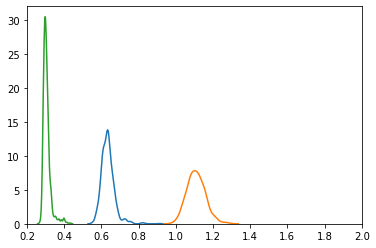

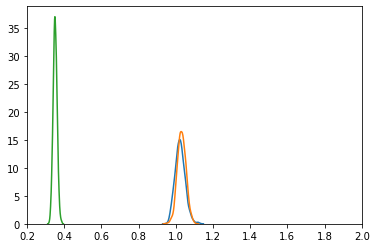

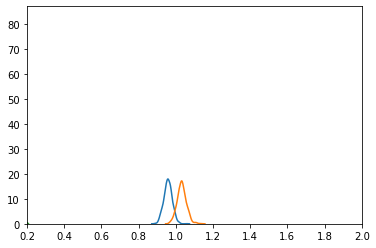

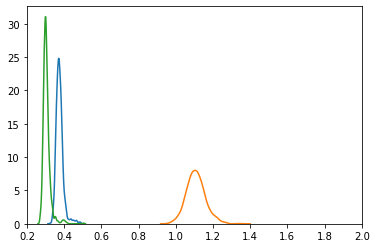

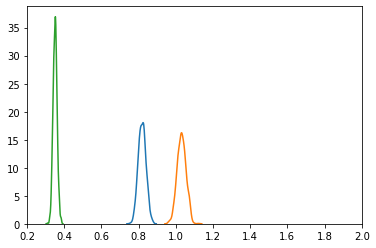

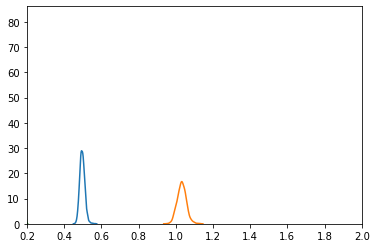

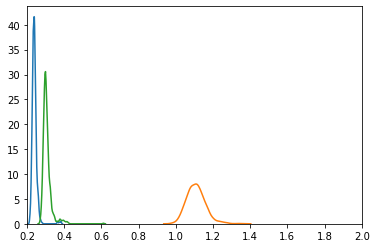

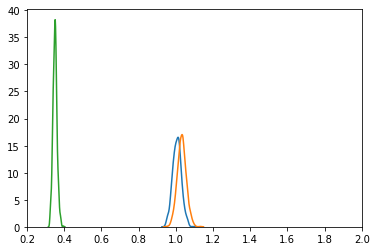

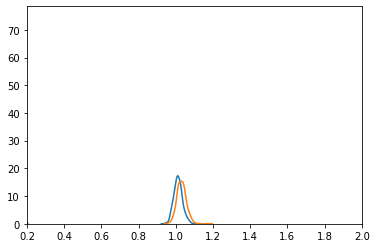

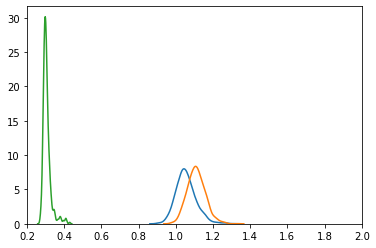

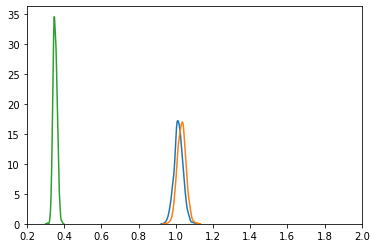

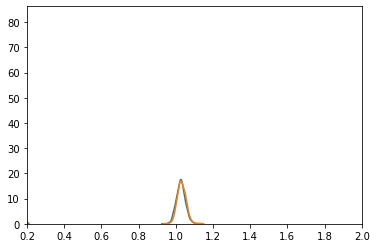

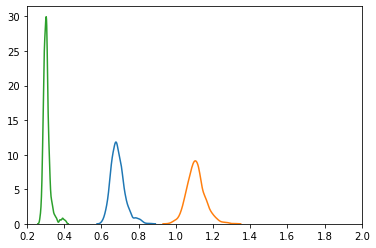

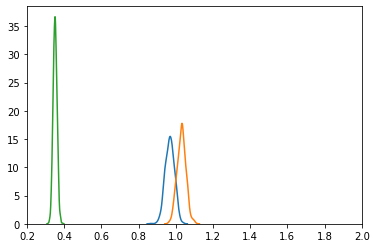

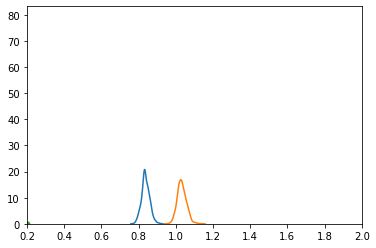

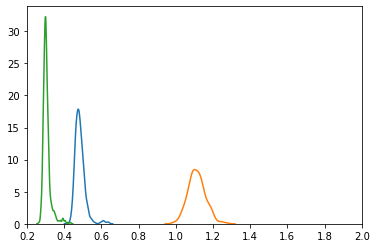

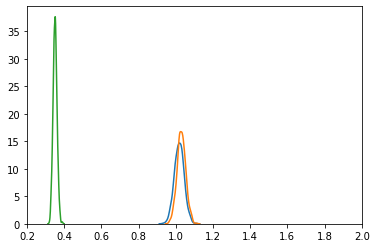

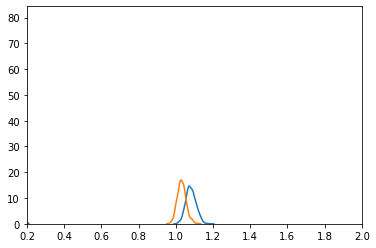

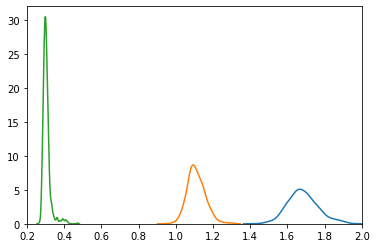

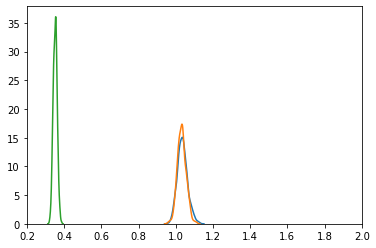

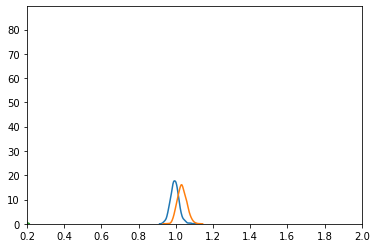

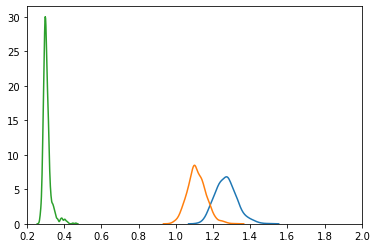

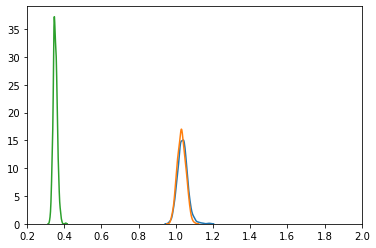

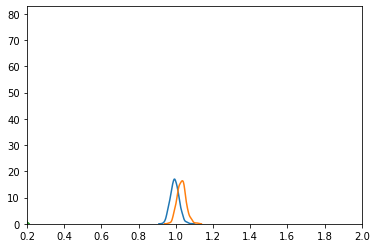

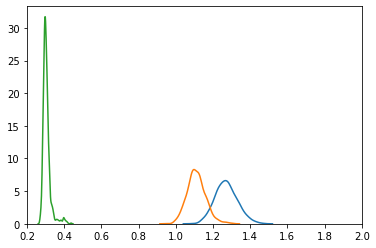

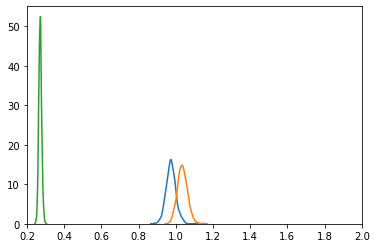

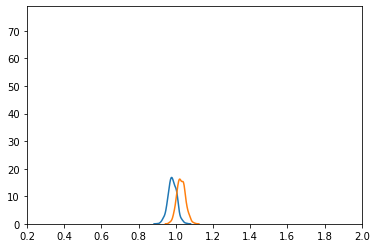

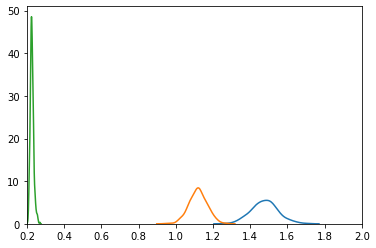

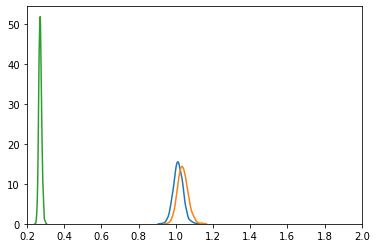

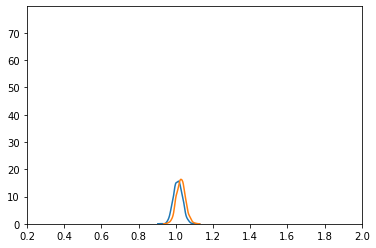

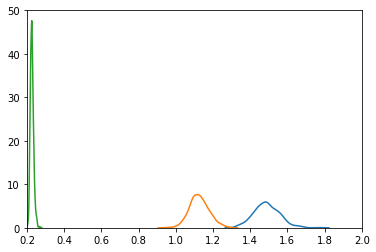

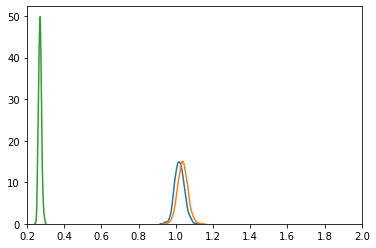

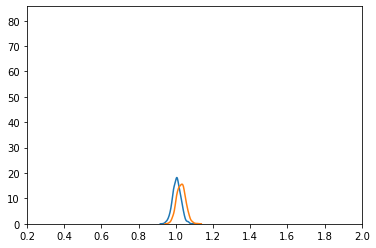

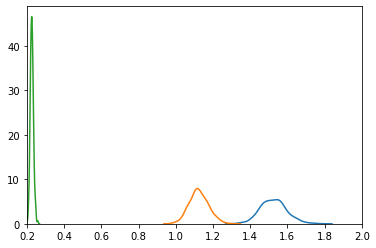

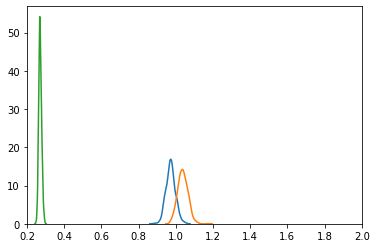

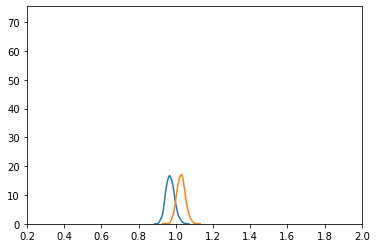

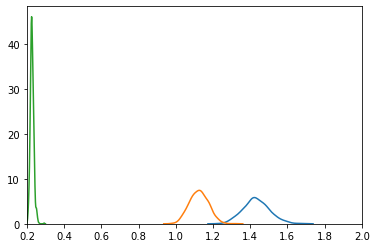

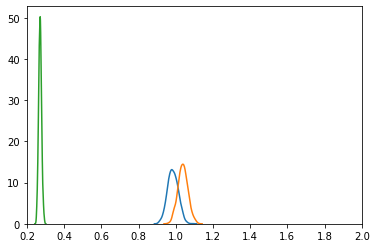

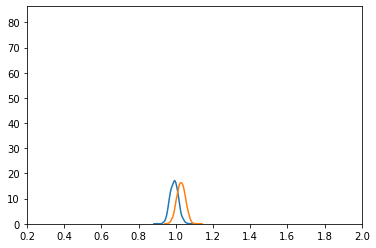

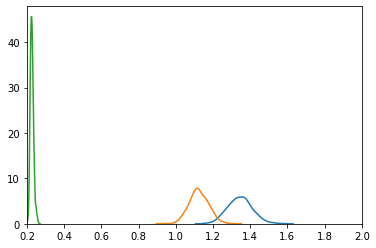

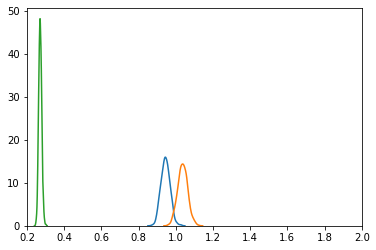

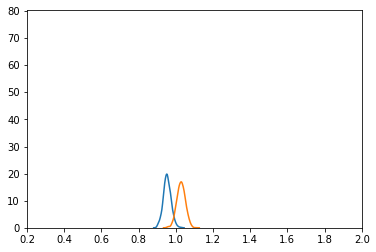

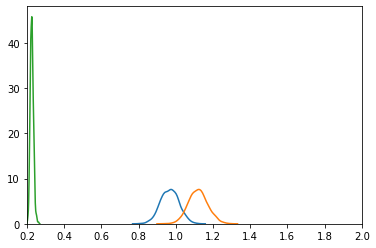

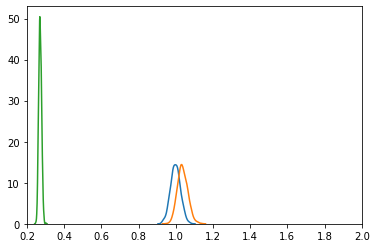

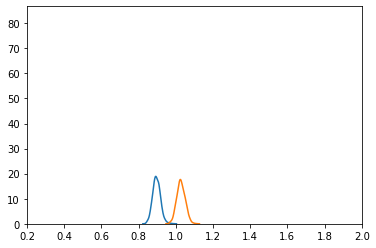

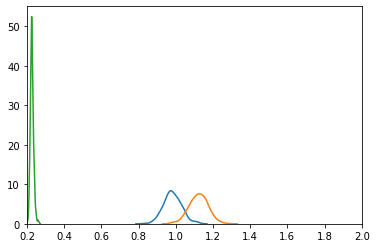

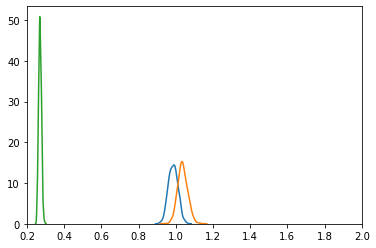

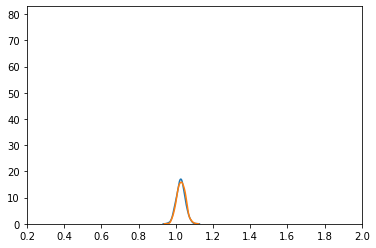

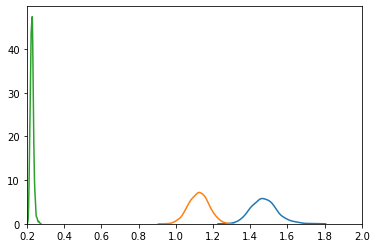

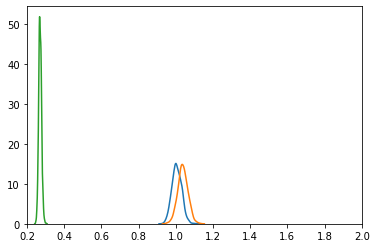

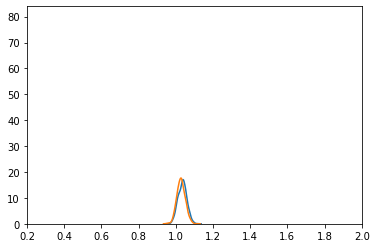

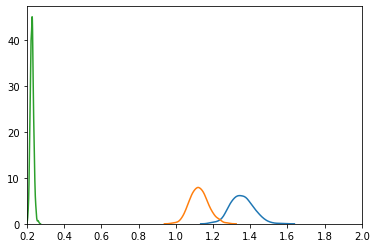

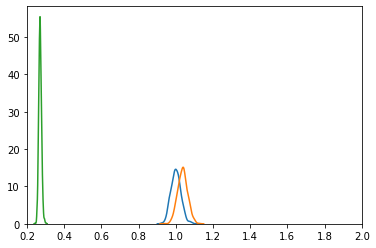

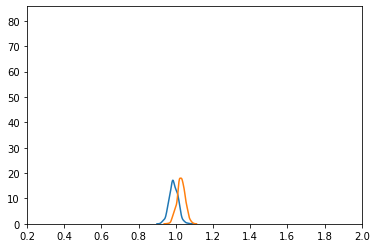

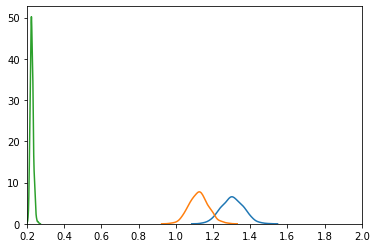

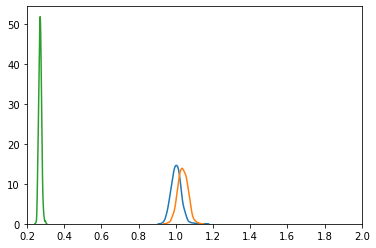

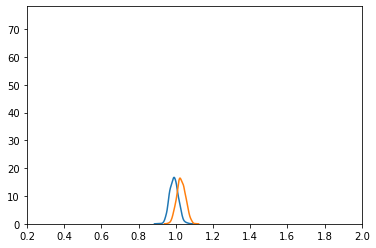

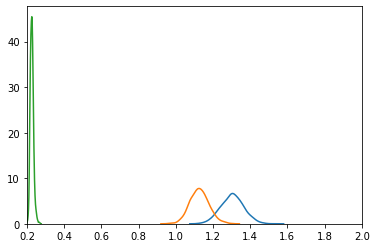

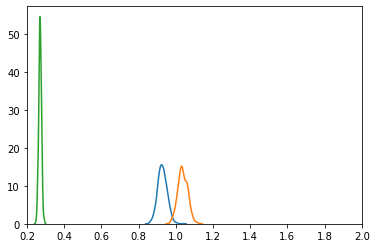

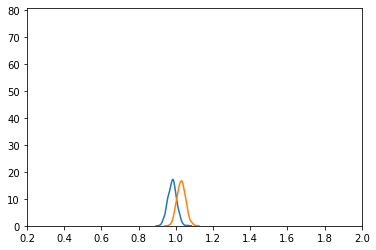

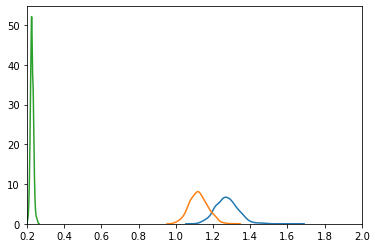

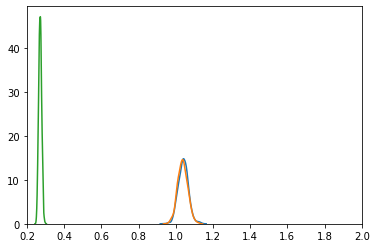

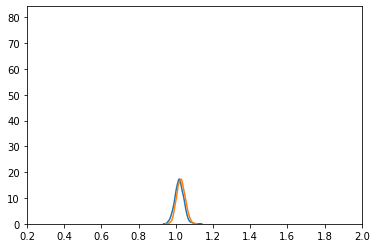

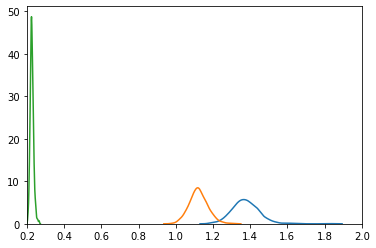

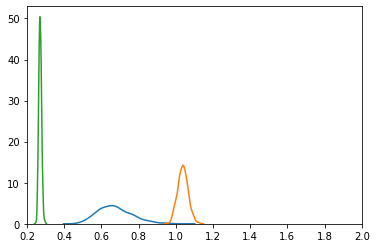

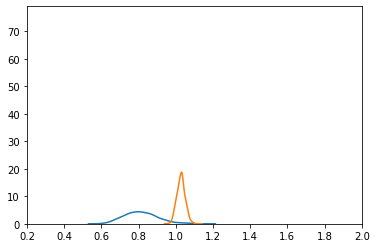

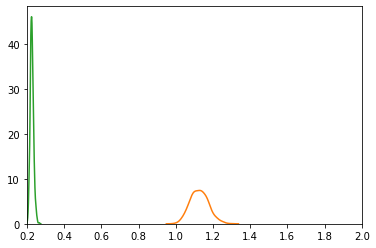

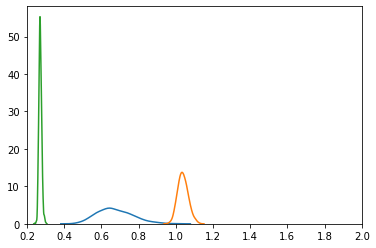

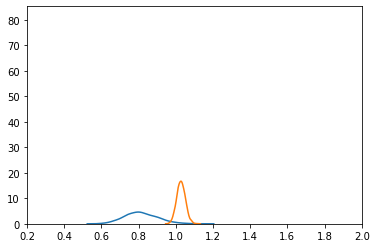

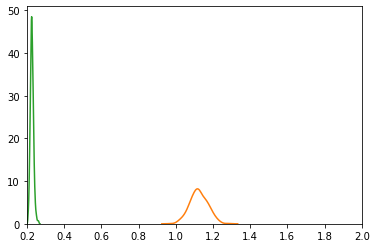

In [174]:
### order is 111, 110, 136
all_mutants_hi = []
for layer1data,layer1dfs in zip(sets,sets_dfs):
    substrates = ['111','110','136']
    i = 0
    for layer2data,layer2dfs in zip(layer1data,layer1dfs):
        ### bootstrap data
        test = bootstrap(pd.DataFrame(layer2data))
        ###  get wt and mutant
        mutant = test.iloc[0]
        wt = test.iloc[1]
        ### create normal distributions from the data and test
        normal_wt = np.random.normal(np.mean(wt),np.std(wt,ddof=1),10000)
        wt_lo = np.percentile(a=normal_wt,q=1.0)
        wt_hi = np.percentile(a=normal_wt,q=99.0)
        normal_item = np.random.normal(np.mean(mutant),np.std(wt,ddof=1),10000)
        overlap = normal_item[normal_item < wt_hi]
        overlap = len(overlap)/len(normal_item)
        ### grab the mutant from the data df
        single = layer2dfs.iloc[0]
        ### combine
        single['pval'] = overlap
        ### name
        single.name = substrates[i]+'_'+single.mutant+'_'+single.subunit
        ### append
        all_mutants_hi.append(single)
        ###
        i+=1

In [175]:
mutants_dist = pd.concat(all_mutants_hi,axis=1,join='inner').transpose()
mutants_dist['substrate'] = mutants_dist.apply(lambda row: row.name.split('_')[0],axis=1)
mutants_dist['mutation'] = mutants_dist.apply(lambda row: row.name.split('_')[1],axis=1)
mutants_dist['subunit'] = mutants_dist.apply(lambda row: row.name.split('_')[2],axis=1)
mutants_dist.to_csv('figures_kde/greatertest.full.final_pvalues.01cutoff.csv')
final = mutants_dist[['substrate','mutation','subunit','pval']]
final.to_csv('figures_kde/greatertest.final_pvalues.01cutoff.csv')